# Processing spectra
In the previous section, we looked at different ways of reading in data and introduced the `ProjectMSI` class. Now we want to process the spectra. We will cover the following steps:
* adding up spectra
* estimating the baseline
* lock-mass calibration
* peak-finding
* binning
* filtering
* creating a feature table
Furthermore, we will look at a method to combine multiple measurements with the same mass window.

Again, we will first investigate the more comprehensive, less elegant approach and afterward, the one using the `ProjectMSI` class.

One of the big challenges that we face for MALDI data specifically is that we have multiple spectra, which are prone to noise. This means that peaks belonging to the same molecule are shifted by a few mDa from spectrum to spectrum. This makes data reduction more challenging since we want to end up with a data cube where each plane corresponds to the ion image of a compound.

## Motivation
Previously, this was tackled by using the line or centroid spectra and performing kernel density estimation on the distribution of masses over all spectra (see https://github.com/weimin-liu/msi_feature_extraction). In this workflow we rely on the profile spectra: firstly, the profile spectra are resampled such that each spectrum contains intensity values at the same masses. A convenient choice is an even sampling, as introduced in the previous section. Notice that it is not possible to add spectra without interpolation because the spectra in the mcf files are sampled at different locations for each spectrum.

One advantage of combining profile spectra before peak picking is that high-frequency noise flattens out and is less likely to be detected as peaks. Furthermore, being able to access the profile spectra is advantageous for calibrations or anything that involves comparing spectra. Conventionally, one would use the line spectra (position of peaks and widths of peaks) to reconstruct the original spectrum. Maintaining the profile spectra on the other hand does not run the risk of biases due to false peaks or inaccurate peak shape estimation. 

Instead of finding the peaks within each spectrum, peaks are estimated from the summed-up spectrum, which we call *kernels* (each kernel represents one compound), and then those kernels are used to estimate the intensities of compounds.

## Step-by-step
With that out of the way, let's take a look at each step. We will also compare the targeted and untargeted approaches, the targeted approach allows a reduction of the number of peaks and is less sensitive to the peak-picking method. This chapter is quite excessive but one of the more important ones. If you are not interested in the details, you may skip to the *Shortcut* section immediatly. 

### Setting up
First of all, we need a reader (either `ReadBrukerMCF` or `hdf5Handler`) and a `Spectra` instance, in this example we will go with the `hdf5Handler` version. Make sure you have a 22.2 MB big *Spectra.hdf5* file inside data > small example > small example.d (download it again from the cloud and move it there, if necessary)

In [1]:
%matplotlib inline
from maspim import Spectra, hdf5Handler

import os
import user_params
# define the path to the .d folder
path_d_folder = os.path.join(user_params.path_folder_test_data, user_params.d_folder_test_data)

C:\Users\Yannick Zander\Downloads\WPy64-31241\python-3.12.4.amd64\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# initiate the reader
reader = hdf5Handler(path_d_folder)

Now let's instanciate the `Spectra` object

In [3]:
spec = Spectra(reader=reader)

The first step is always to add up all spectra (they will be resampled automatically). This method loops over all spectra, which requires reading them all in. This is where the hdf5 file would pay off, but for this toy-example this is not a big concern

In [4]:
spec.add_all_spectra(reader=reader)

Adding spectra: 100%|████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 2106.21it/s]


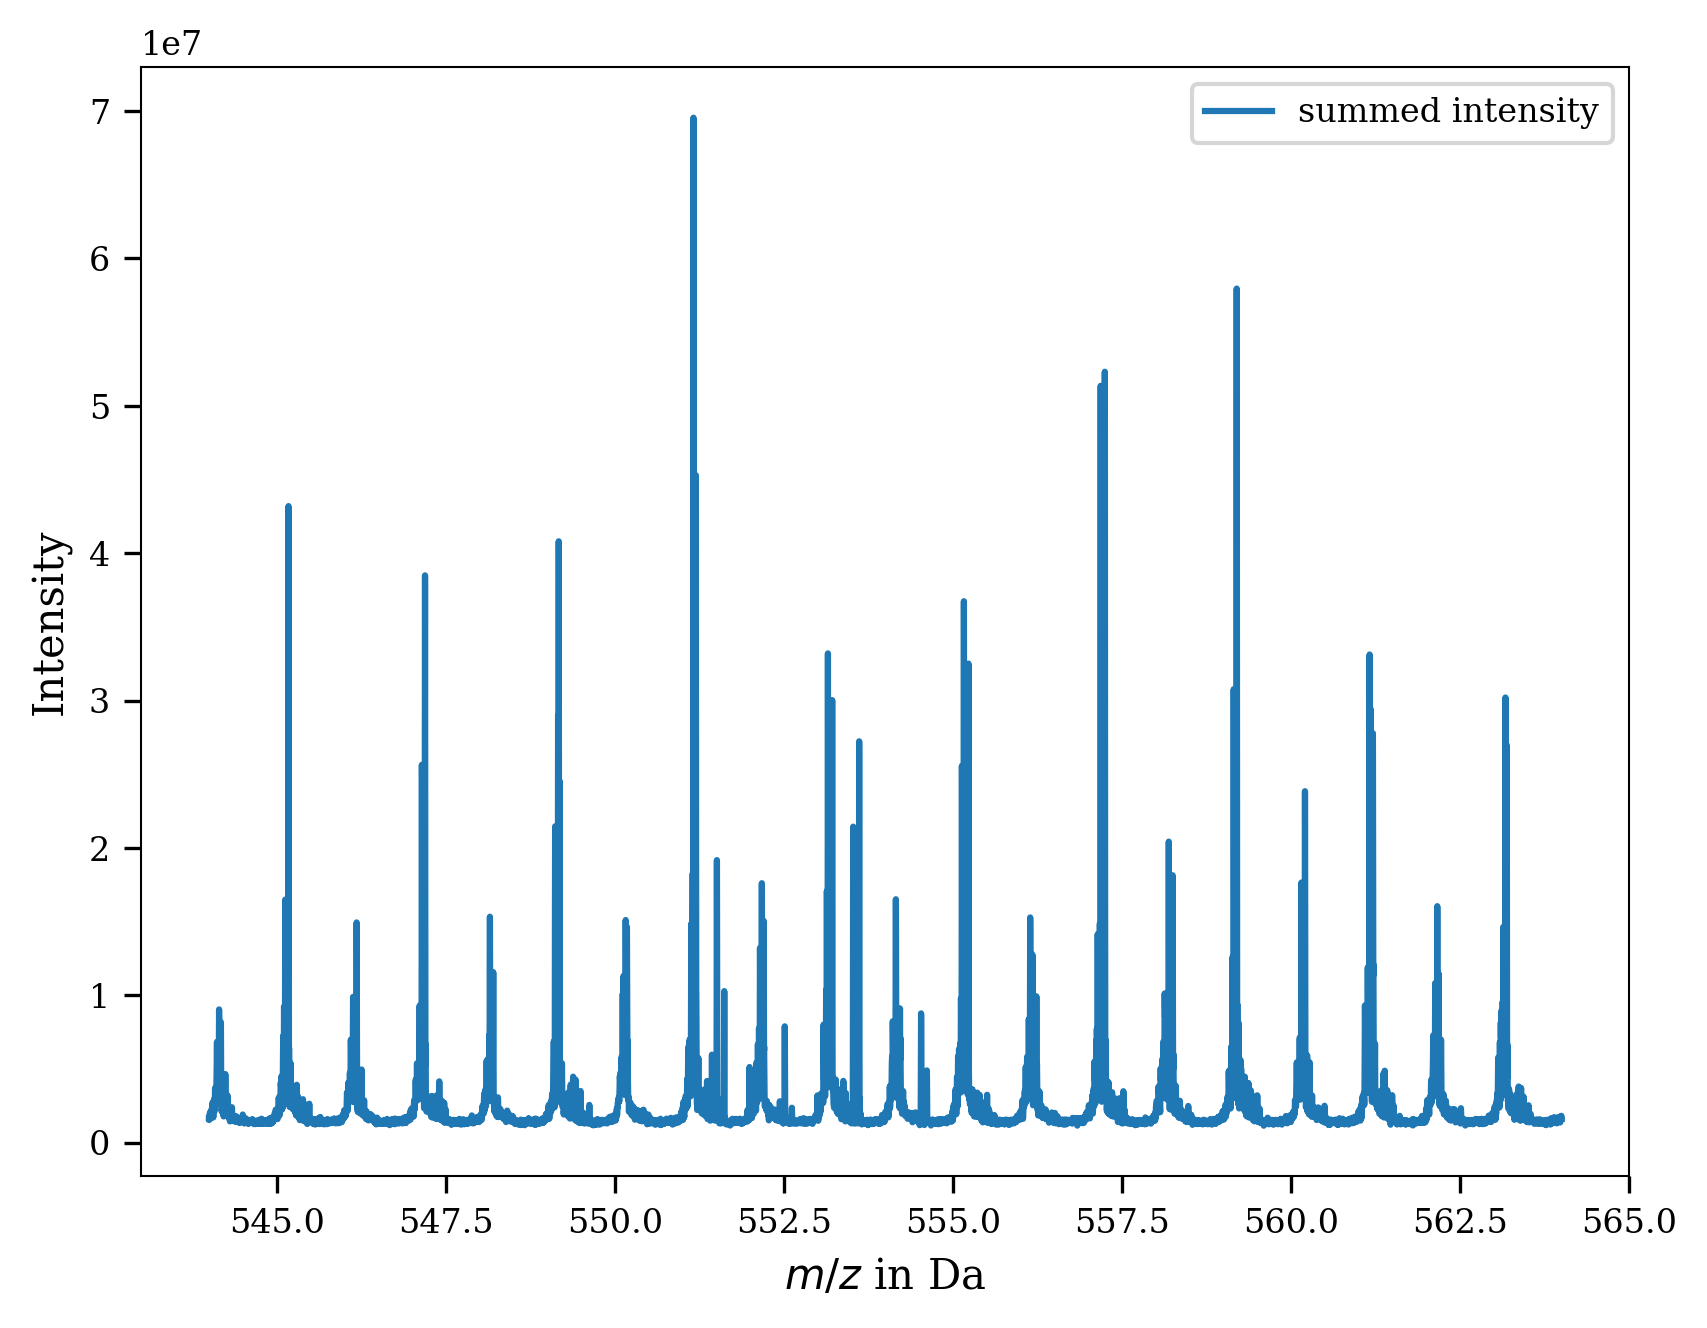

In [5]:
spec.plot_summed()

### Estimating the baseline level
Usually, a substantial baseline is noticeable between peaks. Especially for the kernel estimation, this is annoying. In this pipeline, a minimum filter is used to estimate the baseline level of the summed-up spectrum and afterward removed from the summed spectrum. Within the single spectra, the baseline divided by the number of spectra is used as the noise level.

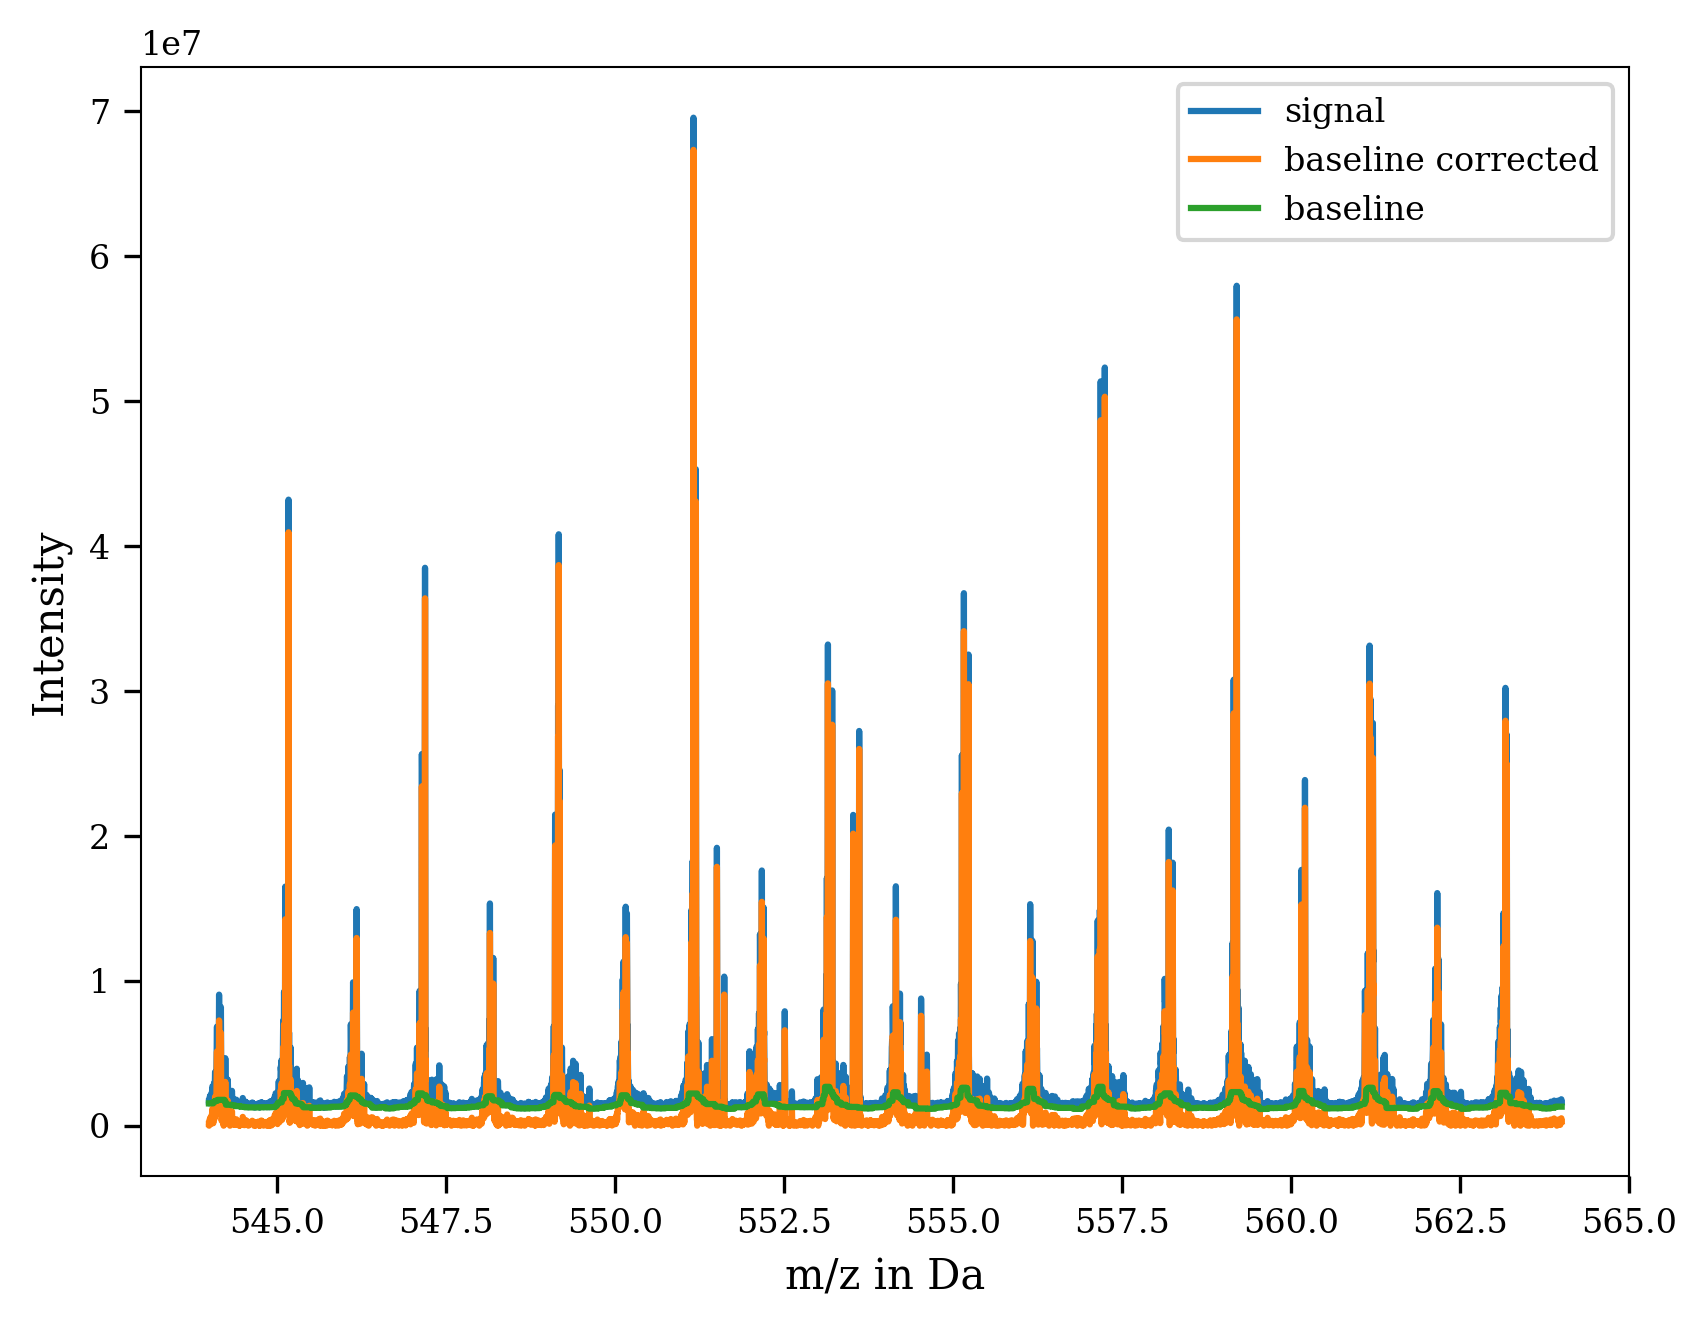

In [6]:
spec.subtract_baseline(plts=True)

### Quiz
which attribute keeps track of whether the noise level has been subtracted?

In [7]:
from tasks import chapter2_task1

chapter2_task1.ask()

### Private methods and variables in python

A note of caution: in this section, we are accessing "private" methods. They don't really exist in `python`, but everything starting with _ is understood to be private, meaning it should not be accessed from outside ... throughout these chapters, we do this a few times for the sake of illustration. Still, generally, if you need to access something private it means that you are doing something in an unintended way.

In [8]:
spec._noise_level

array([21382.23791852, 21382.23791852, 21382.23791852, ...,
       18228.91047205, 18228.91047205, 18228.91047205])

### Window size
The window size of the minimum filter is crucial. Usually, the automatic window-size determination does a good job, but if the window is too small, the baseline creeps into the peaks and we lose the peak shape, so be on the lookout for peaks that look like they collapsed. We can force this by making the window size too small:

Adding spectra: 100%|████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 2290.87it/s]


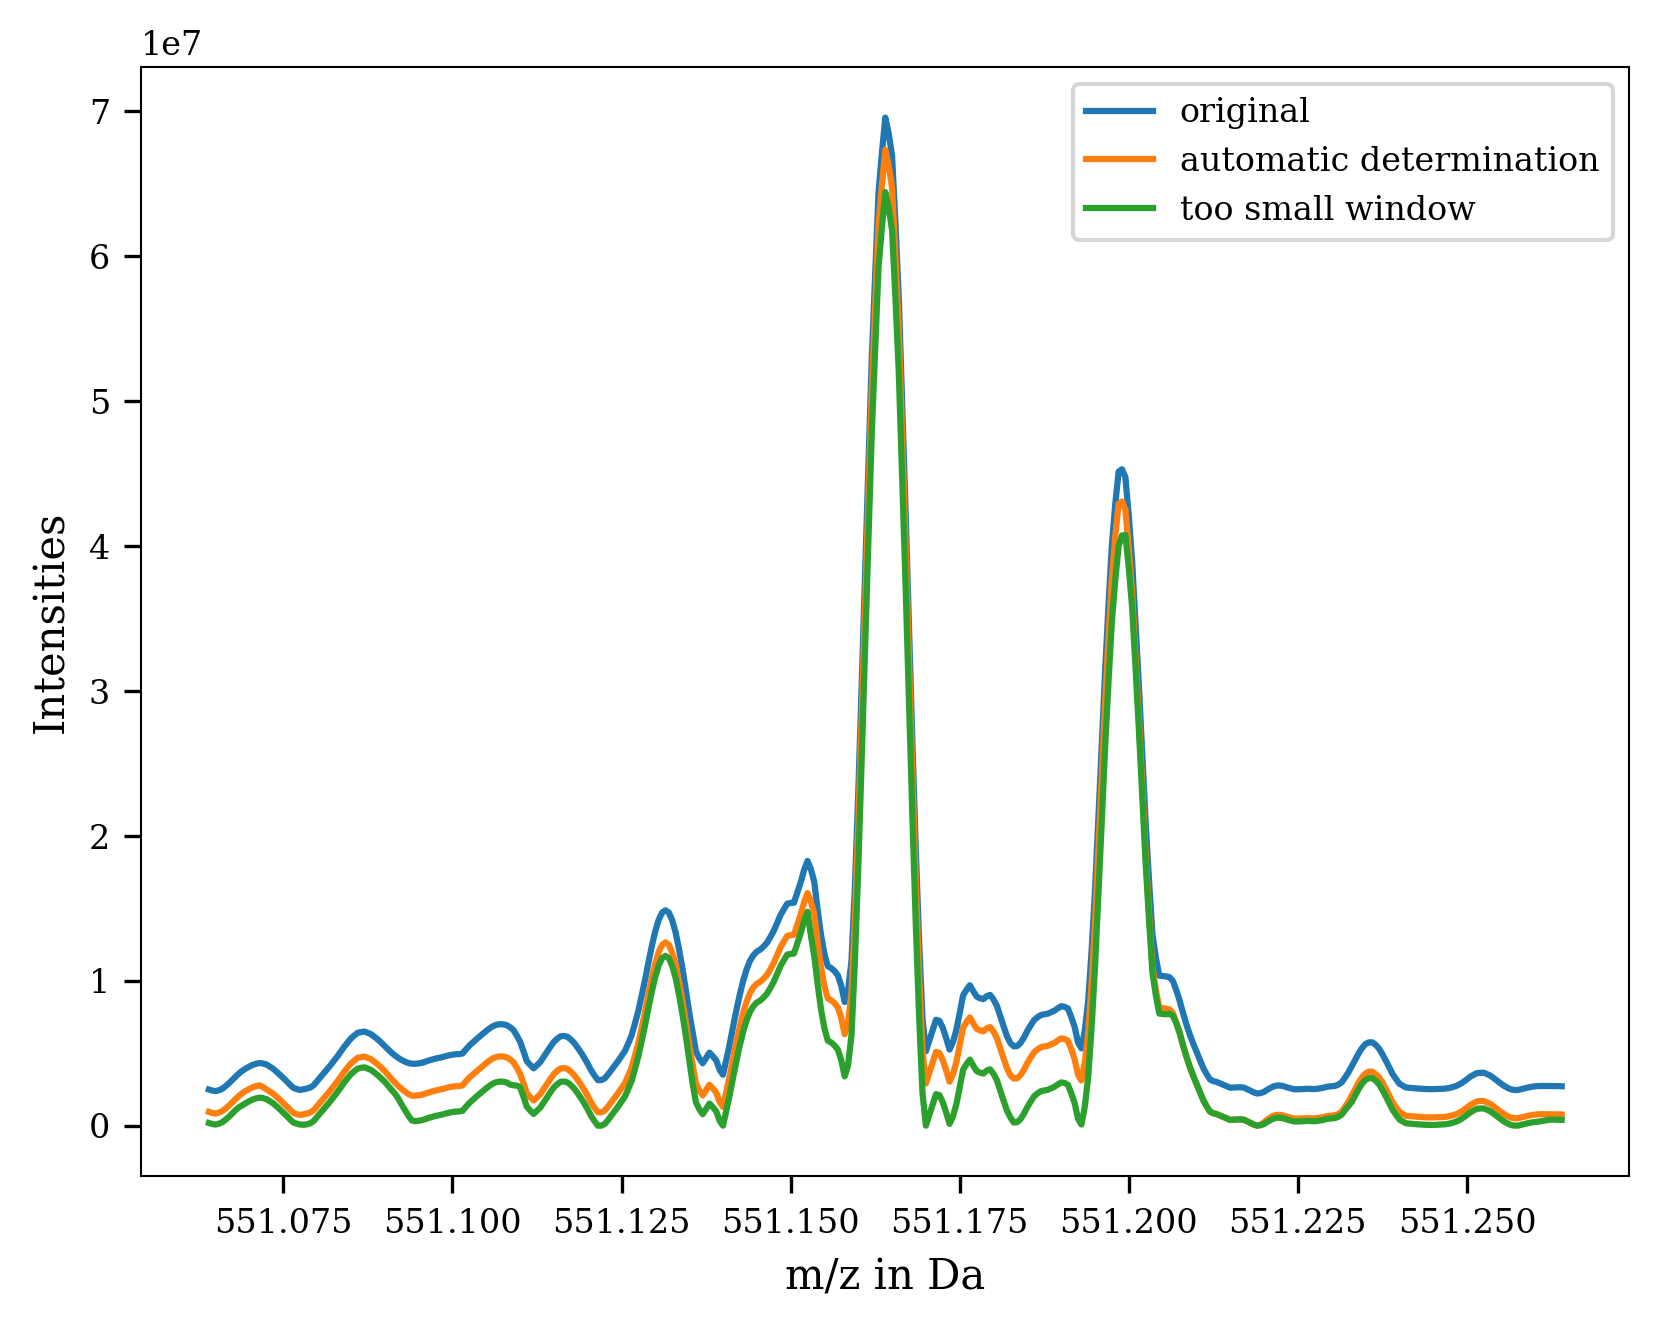

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# window around the largest peak
window_size = .1
center_mz = spec.mzs[np.argmax(spec.intensities)]

mask = (spec.mzs > center_mz - window_size) & (spec.mzs < center_mz + window_size)

spec.add_all_spectra(reader=reader)
plt.plot(spec.mzs[mask], spec.intensities[mask], label='original')

spec.add_all_spectra(reader=reader)
spec.subtract_baseline(overwrite=True)  # window size of .05 Da
plt.plot(spec.mzs[mask], spec.intensities[mask], label='automatic determination')

spec.add_all_spectra(reader=reader)
spec.subtract_baseline(window_size=round(.005 / 1e-4))  # window size of 5 mDa
plt.plot(spec.mzs[mask], spec.intensities[mask], label='too small window')
plt.legend()
plt.xlabel('m/z in Da')
plt.ylabel('Intensities')
plt.show()

The automatic window-size estimation determines the biggest peak width at a relative height of 80% and takes this as the window size. 

In [10]:
# make sure we got a reasonable baseline in the end
spec.add_all_spectra(reader=reader)
spec.subtract_baseline()

Adding spectra: 100%|████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 2233.54it/s]


### Lock-mass calibration
The next step is to make sure that the spectra are aligned. This is achieved by looking for certain calibration masses within each spectrum. Each calibration mass is matched to a peak if it is close and high enough. From the differences, a polynomial is estimated that minimizes the differences between calibration masses and peaks. By default, the compound list suggested by Wörmer et al. (2019, https://doi.org/10.1016/j.orggeochem.2018.11.009) is used. We suggest using a low-degree polynomial because for higher-degree polynomials the correction can become quite large outside the mass range spanned by the calibrant masses. Furthermore, we suggest using a fairly high signal-to-noise ratio (SNR) threshold (by default 4) to make sure that calibrants are not matched to noise peaks. The default search range is 5 mDa. In this example we have to increase the search range because there appears to be a shift that is bigger than 5 mDa. 

What happens if you don't increase the search range? 

INFO:maspim.res.calibrants:No calibrants provided, using [553.5319, 551.5162, 559.4274, 551.4435, 557.2523, 555.2367] from data base.
Finding calibration parameters: 100%|████████████████████████████████████████████████| 72/72 [00:00<00:00, 1698.44it/s]
INFO:maspim.exporting.from_mcf.spectrum:done calibrating spectra, found calibrants in the following abundances:
INFO:maspim.exporting.from_mcf.spectrum:551.4435 : 42%
551.5162 : 64%
553.5319 : 68%
555.2367 : 86%
557.2523 : 90%
559.4274 : 14%
INFO:maspim.res.calibrants:No calibrants provided, using [553.5319, 551.5162, 559.4274, 551.4435, 557.2523, 555.2367] from data base.


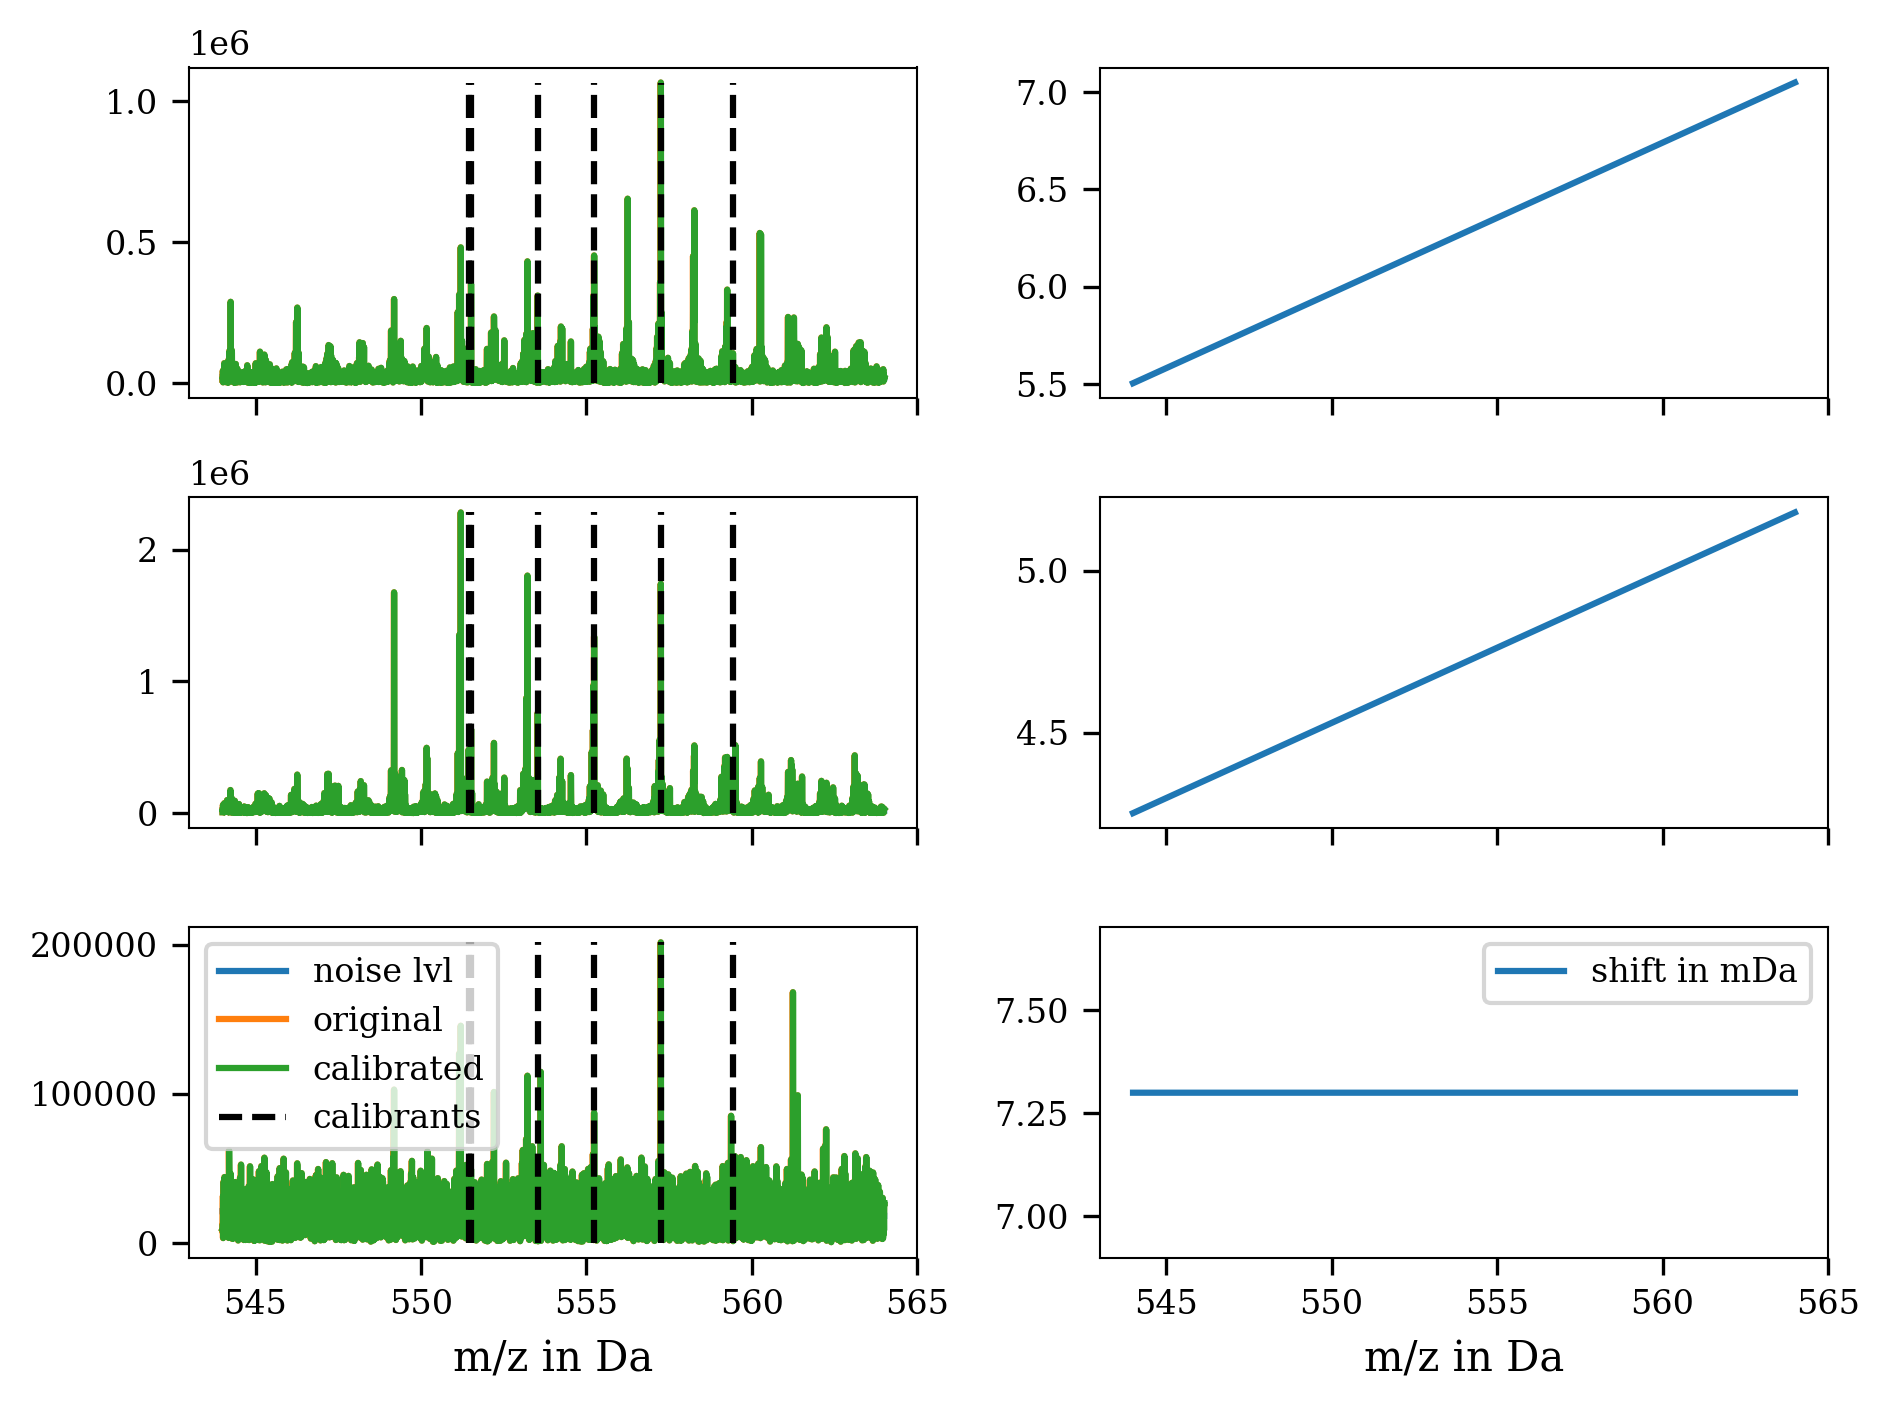

In [11]:
import logging
logging.basicConfig(level=logging.INFO)  # print stats about how often calibrants were found
spec.require_calibration_functions(reader=reader, overwrite=True, search_range=10e-3)
spec.plot_calibration_functions(reader=reader, indices=[5, 7, 9])

Overall the shifts are rather small, as one would expect. In the first case, only one calibrant has been matched, therefore the calibration function is a constant offset. For the last spectrum shown here, no calibrant has been found.

### Quiz
For at least how many spectra was no calibrant found (in %)?

In [12]:
from tasks import chapter2_task2

chapter2_task2.ask()

After we found our calibration functions, we need to add up the spectra again, this time using the calibrated spectra (once you set the calibration functions, each time a spectrum is fetched from a reader, it will be calibrated automatically) and subtract the baseline again

In [13]:
spec.add_all_spectra(reader)
spec.subtract_baseline()

Adding spectra: 100%|████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 1502.21it/s]
INFO:maspim.exporting.from_mcf.spectrum:done adding up spectra
INFO:maspim.exporting.from_mcf.spectrum:estimated window size for baseline subtraction is 21.1 mDa


By the way, all steps above can be shortcutted using

In [14]:
spec.add_calibrated_spectra(reader=reader, search_range=10e-3)

Adding spectra: 100%|████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 1575.37it/s]
INFO:maspim.exporting.from_mcf.spectrum:done adding up spectra
INFO:maspim.exporting.from_mcf.spectrum:estimated window size for baseline subtraction is 21.1 mDa
Adding spectra: 100%|████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 1568.62it/s]
INFO:maspim.exporting.from_mcf.spectrum:done adding up spectra
INFO:maspim.exporting.from_mcf.spectrum:estimated window size for baseline subtraction is 21.1 mDa


### Loading and saving
In the next section, we will investigate two different ways of proceeding, the targeted and untargeted approach. Therefore, it would be handy to create a savepoint.

We can save the object to disk, such that we can just load it the next time we need it and do not have to perform all the steps again. Calling `save` will create a file inside of the .d folder called *Spectra.pickle*

In [15]:
spec.save()

INFO:maspim.util.convenience:saving image object with {'_kernel_params', '_binning_by', '_delta_mz', '_calibration_settings', '_limits', '_feature_table', '_noise_level_subtracted', '_calibration_parameters', '_peaks', '_indices', '_peak_setting_parameters', '_peaks_is_side_peak', '_intensities', '_mzs', '_noise_level_parameters', '_noise_level', '_line_spectra', '_tic', '_kernel_shape', '_peak_properties', '_peaks_SNR'} to C:\Users\Yannick Zander\Downloads\maspim workshop\data\small example\small example.d


Loading works like this

In [16]:
spec = Spectra(path_d_folder=path_d_folder, initiate=False)
spec.load()

INFO:maspim.util.convenience:loaded Spectra with keys {'_kernel_params', '_binning_by', '_delta_mz', '_calibration_settings', '_limits', '_feature_table', '_noise_level_subtracted', '_calibration_parameters', '_peaks', '_indices', '_peak_setting_parameters', '_peaks_is_side_peak', '_intensities', '_mzs', '_noise_level_parameters', '_noise_level', '_line_spectra', '_tic', '_kernel_shape', '_peak_properties', '_peaks_SNR'}


### Targeted approach
If you are only interested in certain compounds, you can specify them in this step (and also you don't have to worry about the peak filtering). Here we will show how to target the compounds needed to calculate the Uk37 proxy. By default, this method picks the nearest peak for each target within a given tolerance. The tolerance will be the median kernel width, if not provided, but should be in the range of 3 to 5 mDa). 

INFO:maspim.util.convenience:loaded Spectra with keys {'_kernel_params', '_binning_by', '_delta_mz', '_calibration_settings', '_limits', '_feature_table', '_noise_level_subtracted', '_calibration_parameters', '_peaks', '_indices', '_peak_setting_parameters', '_peaks_is_side_peak', '_intensities', '_mzs', '_noise_level_parameters', '_noise_level', '_line_spectra', '_tic', '_kernel_shape', '_peak_properties', '_peaks_SNR'}
INFO:root:keeping 2 whitelisted out of 1740 peaks


[19055, 15025] [553.53188756536, 551.51623750122] [0.005, 0.005]


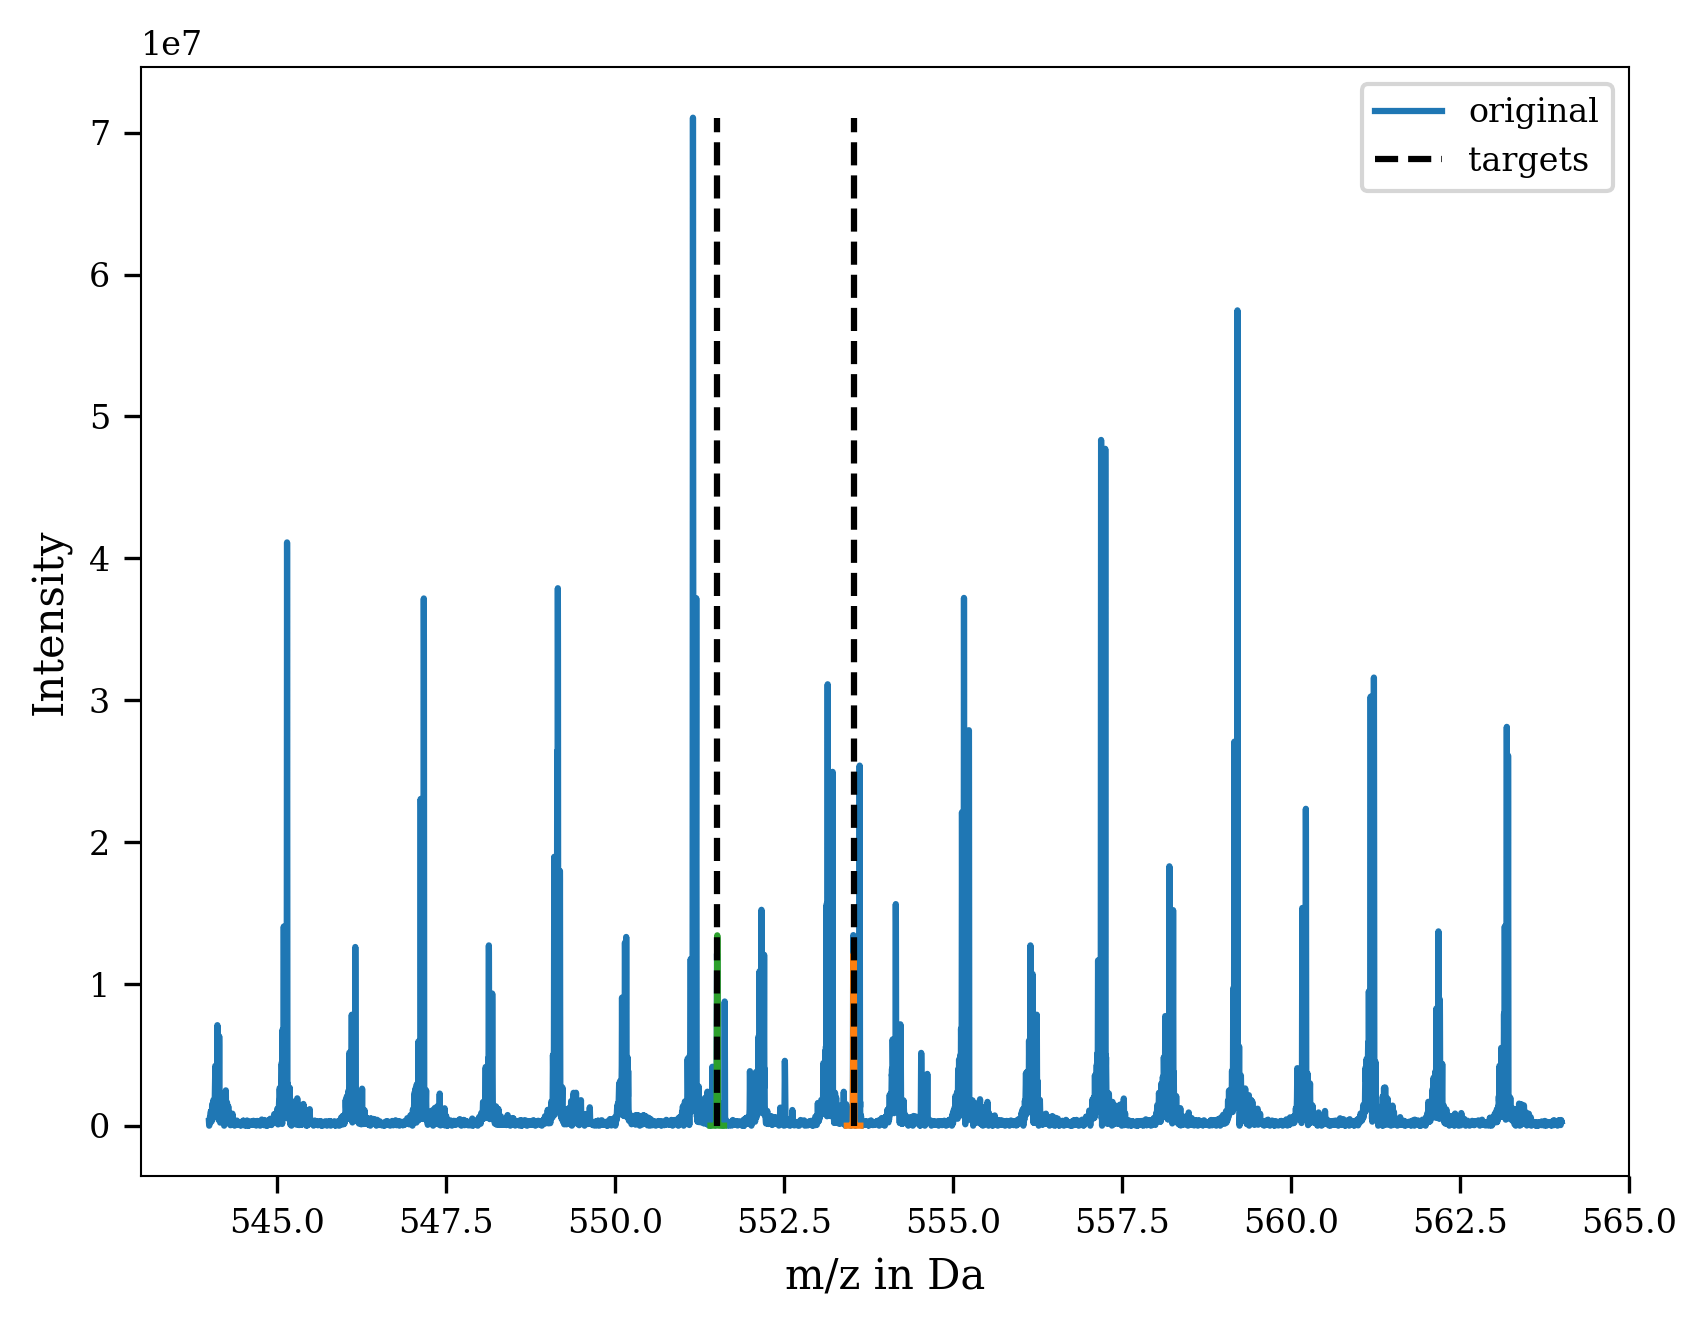

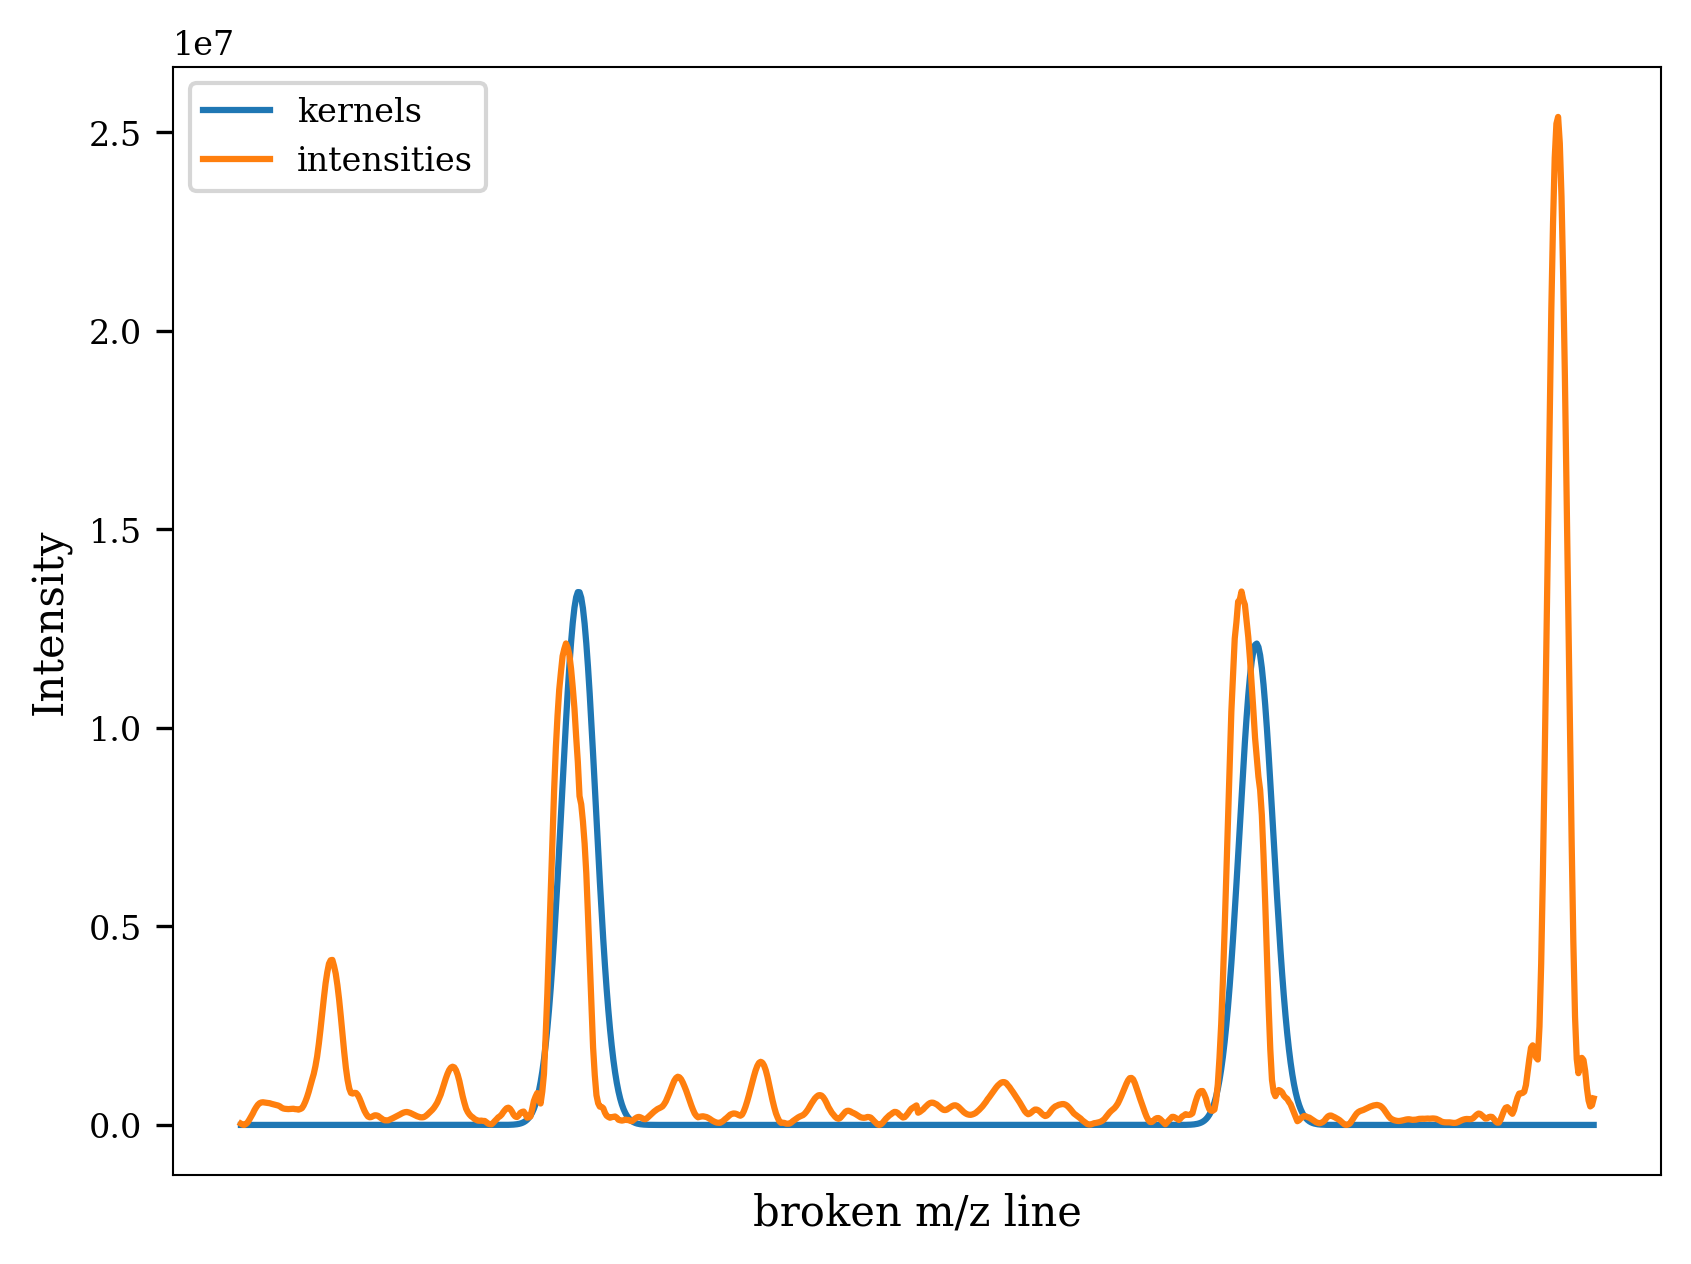

binning spectra: 100%|███████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 1540.68it/s]


In [17]:
from maspim.res.compound_masses import mass_C37_2_Na_p, mass_C37_3_Na_p
spec = Spectra(path_d_folder=path_d_folder, initiate=False)
spec.load()
spec.set_targets(targets=[mass_C37_2_Na_p, mass_C37_3_Na_p], 
                 tolerances=5e-3, 
                 plts=True, 
                 reader=reader, 
                 method_peak_center='closest')

Now we binned the spectra but are still missing the filtering. If you are not interested in the untargeted approach or want to follow this path, skip to the section *Filter intensities*. 

### Untargeted approach
Now let's proceed with the untargeted approach. We will continue after

In [18]:
spec = Spectra(path_d_folder=path_d_folder, initiate=False)
spec.load()

INFO:maspim.util.convenience:loaded Spectra with keys {'_kernel_params', '_binning_by', '_delta_mz', '_calibration_settings', '_limits', '_feature_table', '_noise_level_subtracted', '_calibration_parameters', '_peaks', '_indices', '_peak_setting_parameters', '_peaks_is_side_peak', '_intensities', '_mzs', '_noise_level_parameters', '_noise_level', '_line_spectra', '_tic', '_kernel_shape', '_peak_properties', '_peaks_SNR'}


#### Peak finding
Now that the baseline is removed and the spectra are calibrated, we are ready to estimate the peaks. The most important parameter for setting the peaks is the prominence (0.1 by default, in terms of median intensity), a lower value will result in more peaks. This is a wrapper around scipy's `signal.find_peaks`

In [19]:
spec.set_peaks()

We can filter out peaks, for example by requiring a certain SNR threshold (we'd recommend using a threshold of at least 1, but further downstream there is another opportunity to filter out low SNR signals):

INFO:root:keeping 292 out of 1740 peaks with SNR above 1


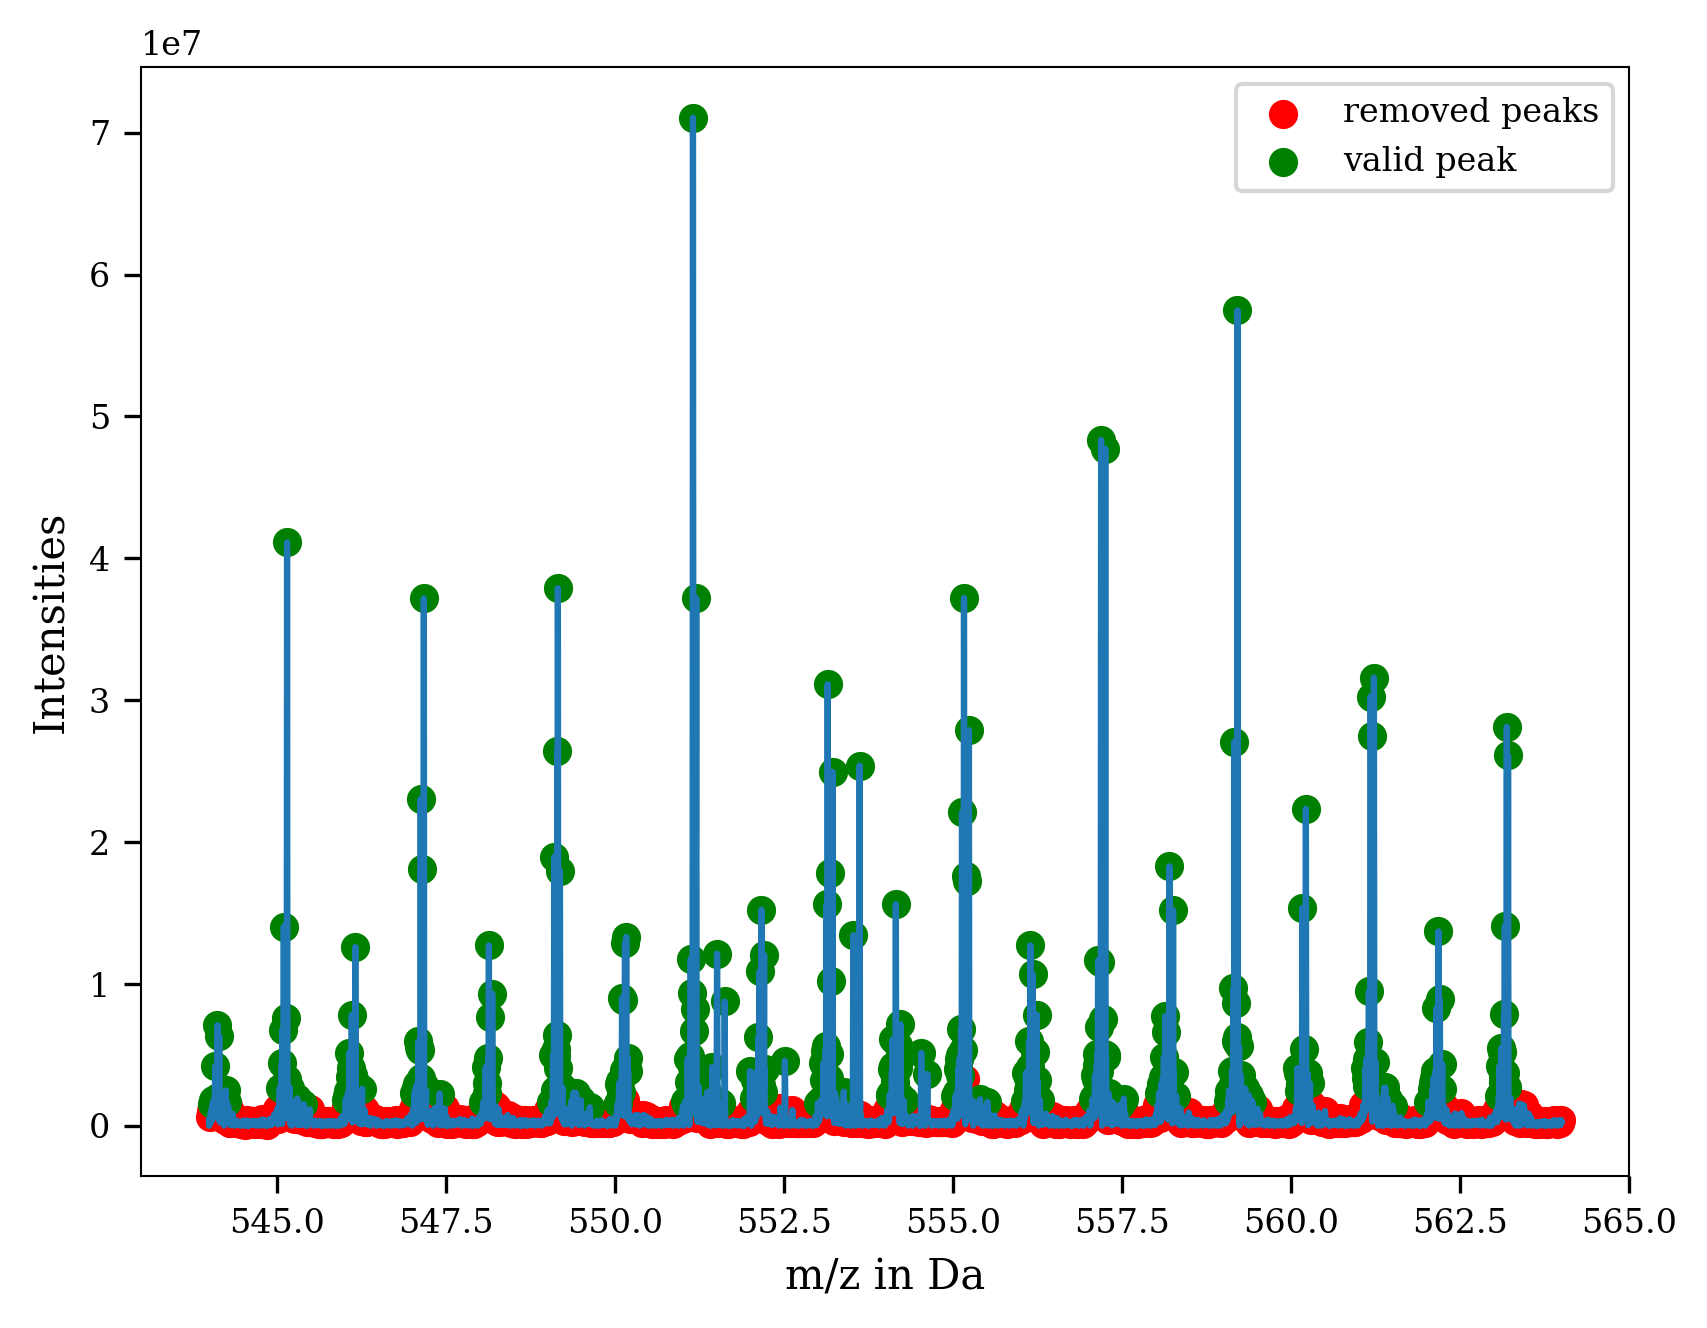

In [20]:
spec.set_peaks()
SNR_threshold = 1
spec.filter_peaks(peaks_snr_threshold=SNR_threshold, plts=True)

Usually 1 is a good value but for only 72 spectra the noise level estimation is not very good.

We can also filter artifacts by detecting side-peaks (which are artifacts from the fourier transform), but usually they are quite low in there intensities and not a big concern

INFO:root:Removing 0 peaks identified as side peaks


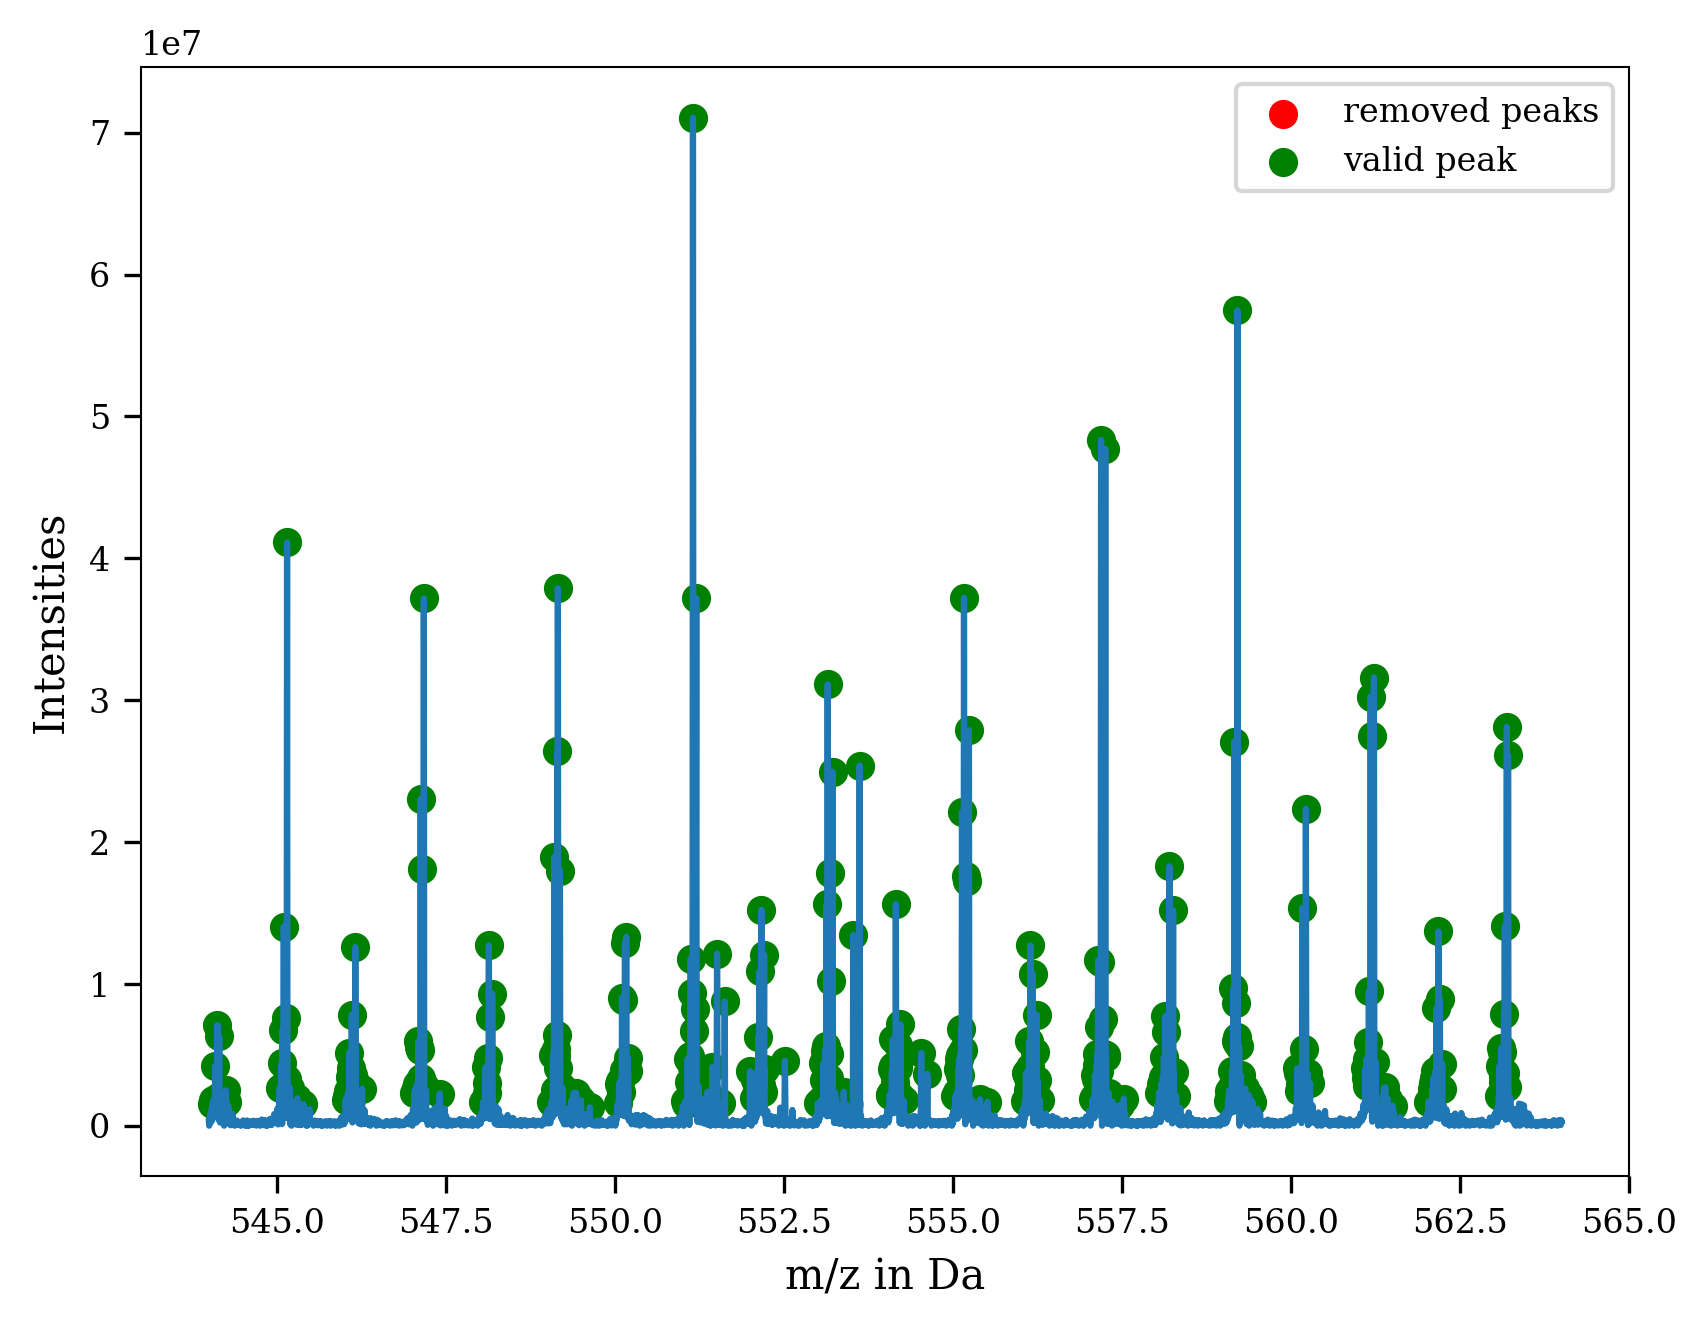

In [21]:
remove_sidepeaks = True
if remove_sidepeaks:
    spec.filter_peaks(remove_sidepeaks=remove_sidepeaks, plts=True)

#### Kernel estimation
Now that we found our peaks, we need to define which section of the spectrum belongs to each peak and where the centers of peaks are. The `Spectra` class implements a method that fits a Gaussian around each peak, making it robust against non-ideal peak shapes. It is also possible to estimate the kernels just from the height and width, which is more robust against very weird peak-shapes, but less accurate. Usually, you will encounter a few warnings for peaks where the peak parameters can not be estimated (especially for lower snr thresholds). Those can be co-eluting peaks or small artifacts and generally are nothing to worry about. If you want to make sure, you can check out the peaks afterward

In [22]:
spec.set_kernels(sigma_max=5e-3)

setting peak parameters:  25%|█████████████▊                                         | 73/292 [00:00<00:00, 362.43it/s]WARNING:maspim.exporting.from_mcf.spectrum:sigma of kernel (5.2 mDa) with index 145 is bigger than max (5.0 mDa), halfing sigma.
 `x0` is infeasible. 
This can happen for double peaks.
 `x0` is infeasible. 
This can happen for double peaks.
setting peak parameters:  38%|████████████████████▌                                 | 111/292 [00:00<00:00, 366.77it/s]WARNING:maspim.exporting.from_mcf.spectrum:sigma of kernel (7.9 mDa) with index 28 is bigger than max (5.0 mDa), halfing sigma.
 `x0` is infeasible. 
This can happen for double peaks.
 `x0` is infeasible. 
This can happen for double peaks.
setting peak parameters:  51%|███████████████████████████▌                          | 149/292 [00:00<00:00, 370.91it/s]WARNING:maspim.exporting.from_mcf.spectrum:sigma of kernel (7.8 mDa) with index 207 is bigger than max (5.0 mDa), halfing sigma.
 `x0` is infeasible. 
This can ha

Let's check those sporious peaks out (we have to set the peaks again, because the sporious peaks will be removed within `set_kernels`)

INFO:root:keeping 292 out of 1740 peaks with SNR above 1
INFO:root:Removing 0 peaks identified as side peaks


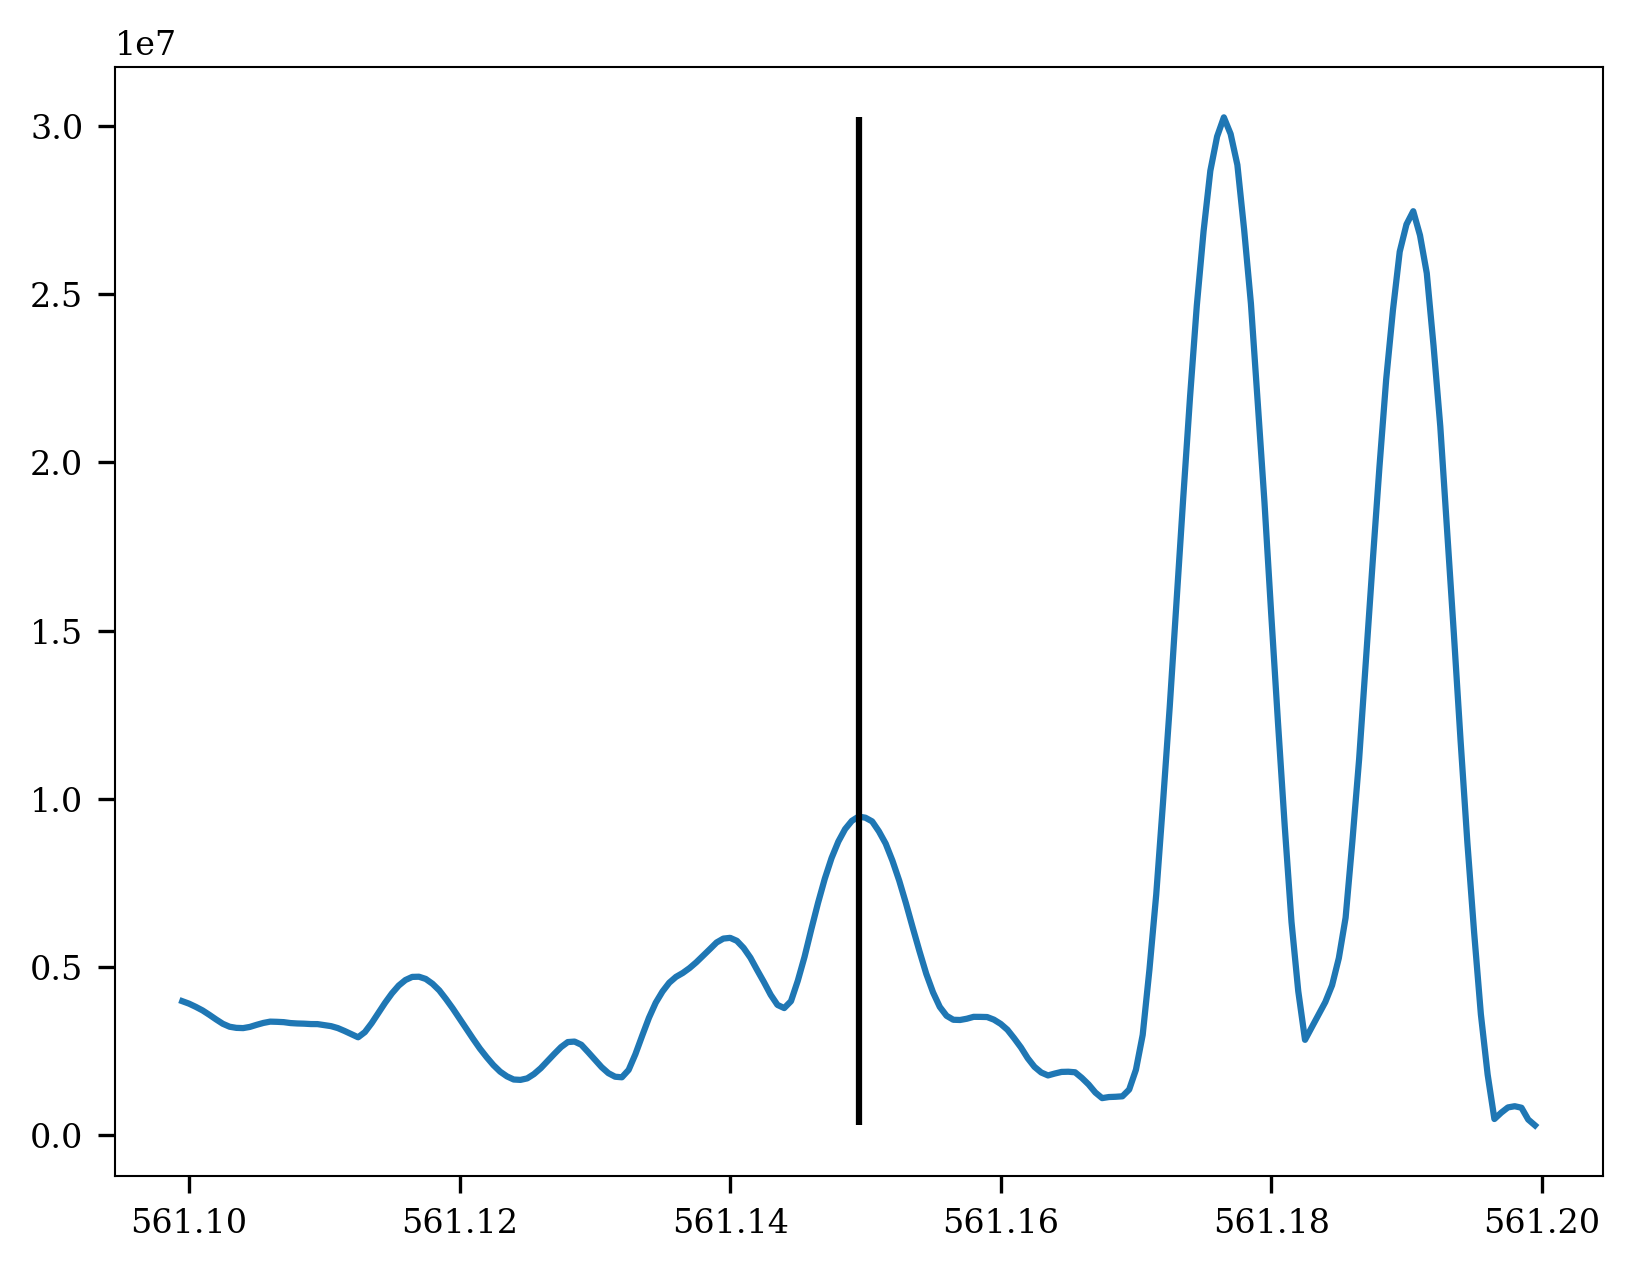

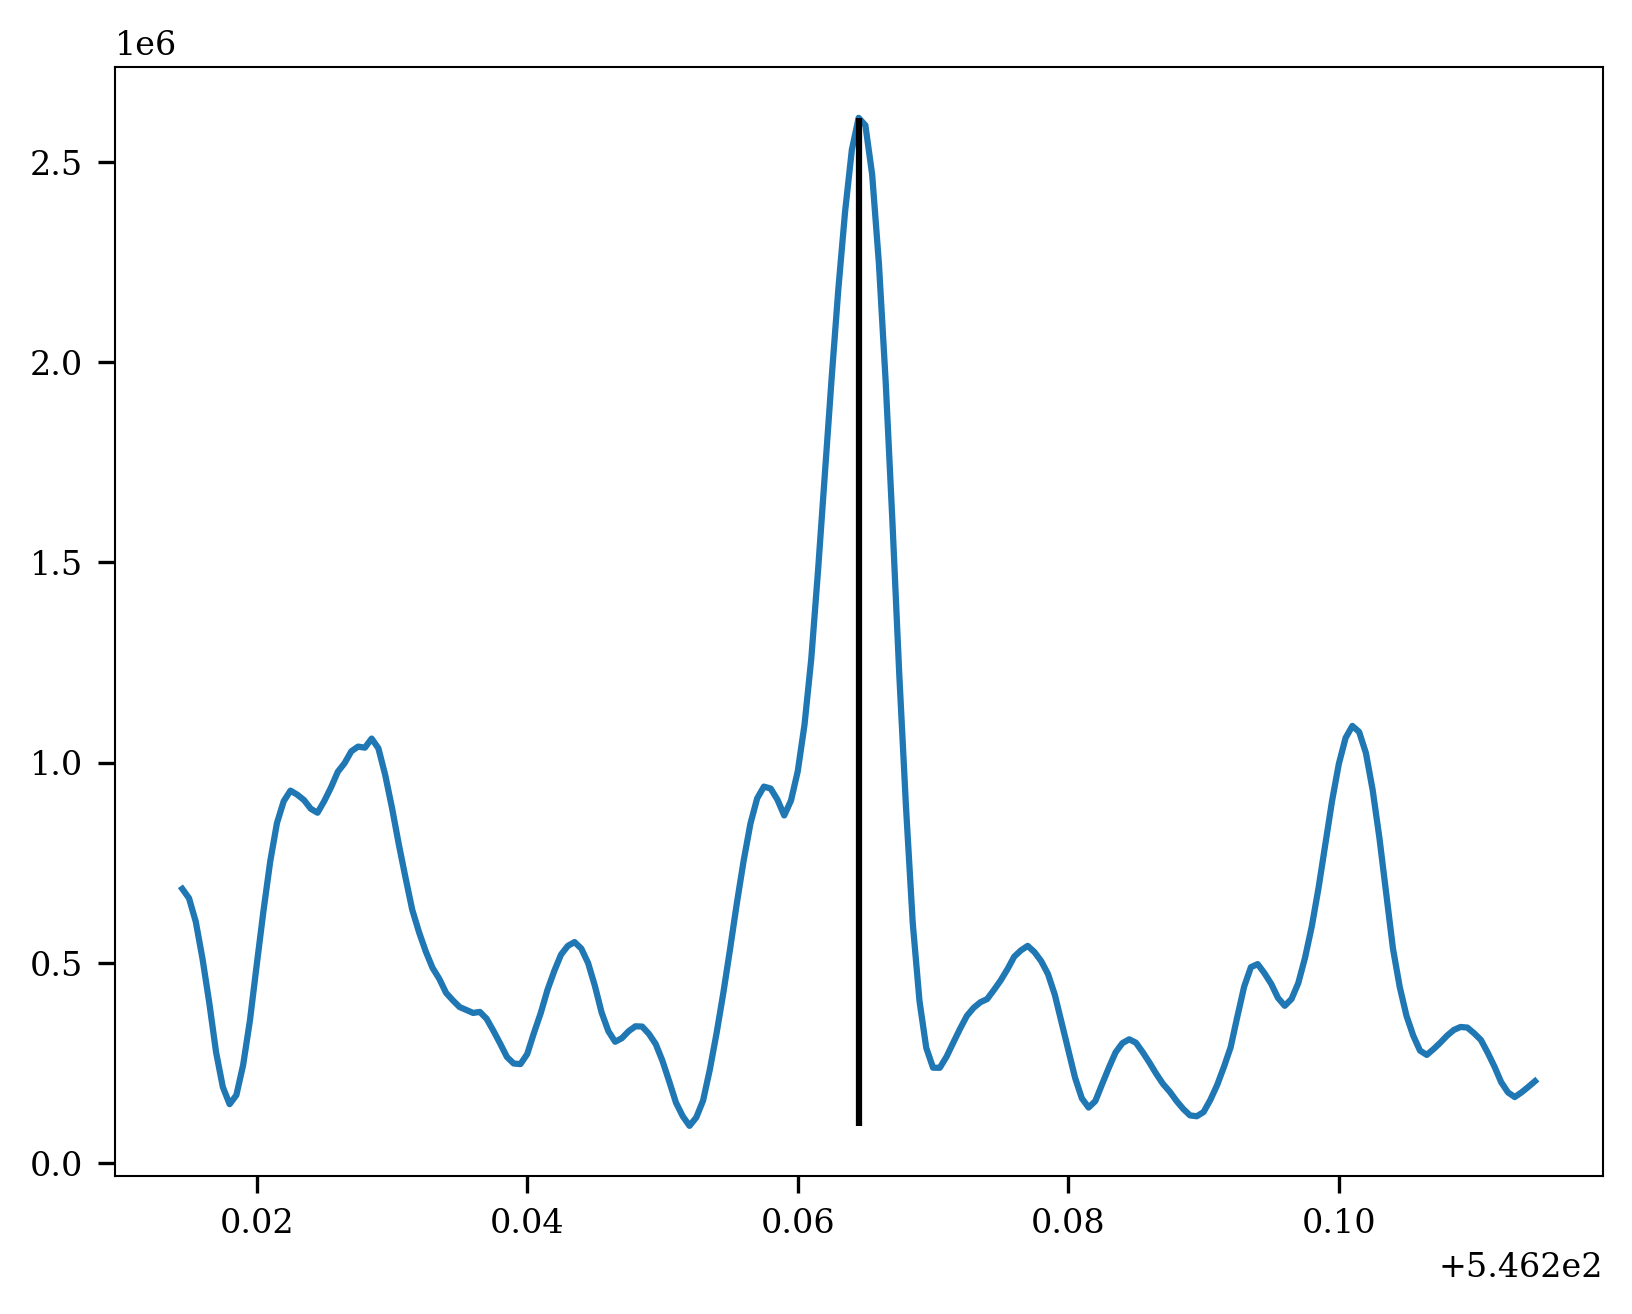

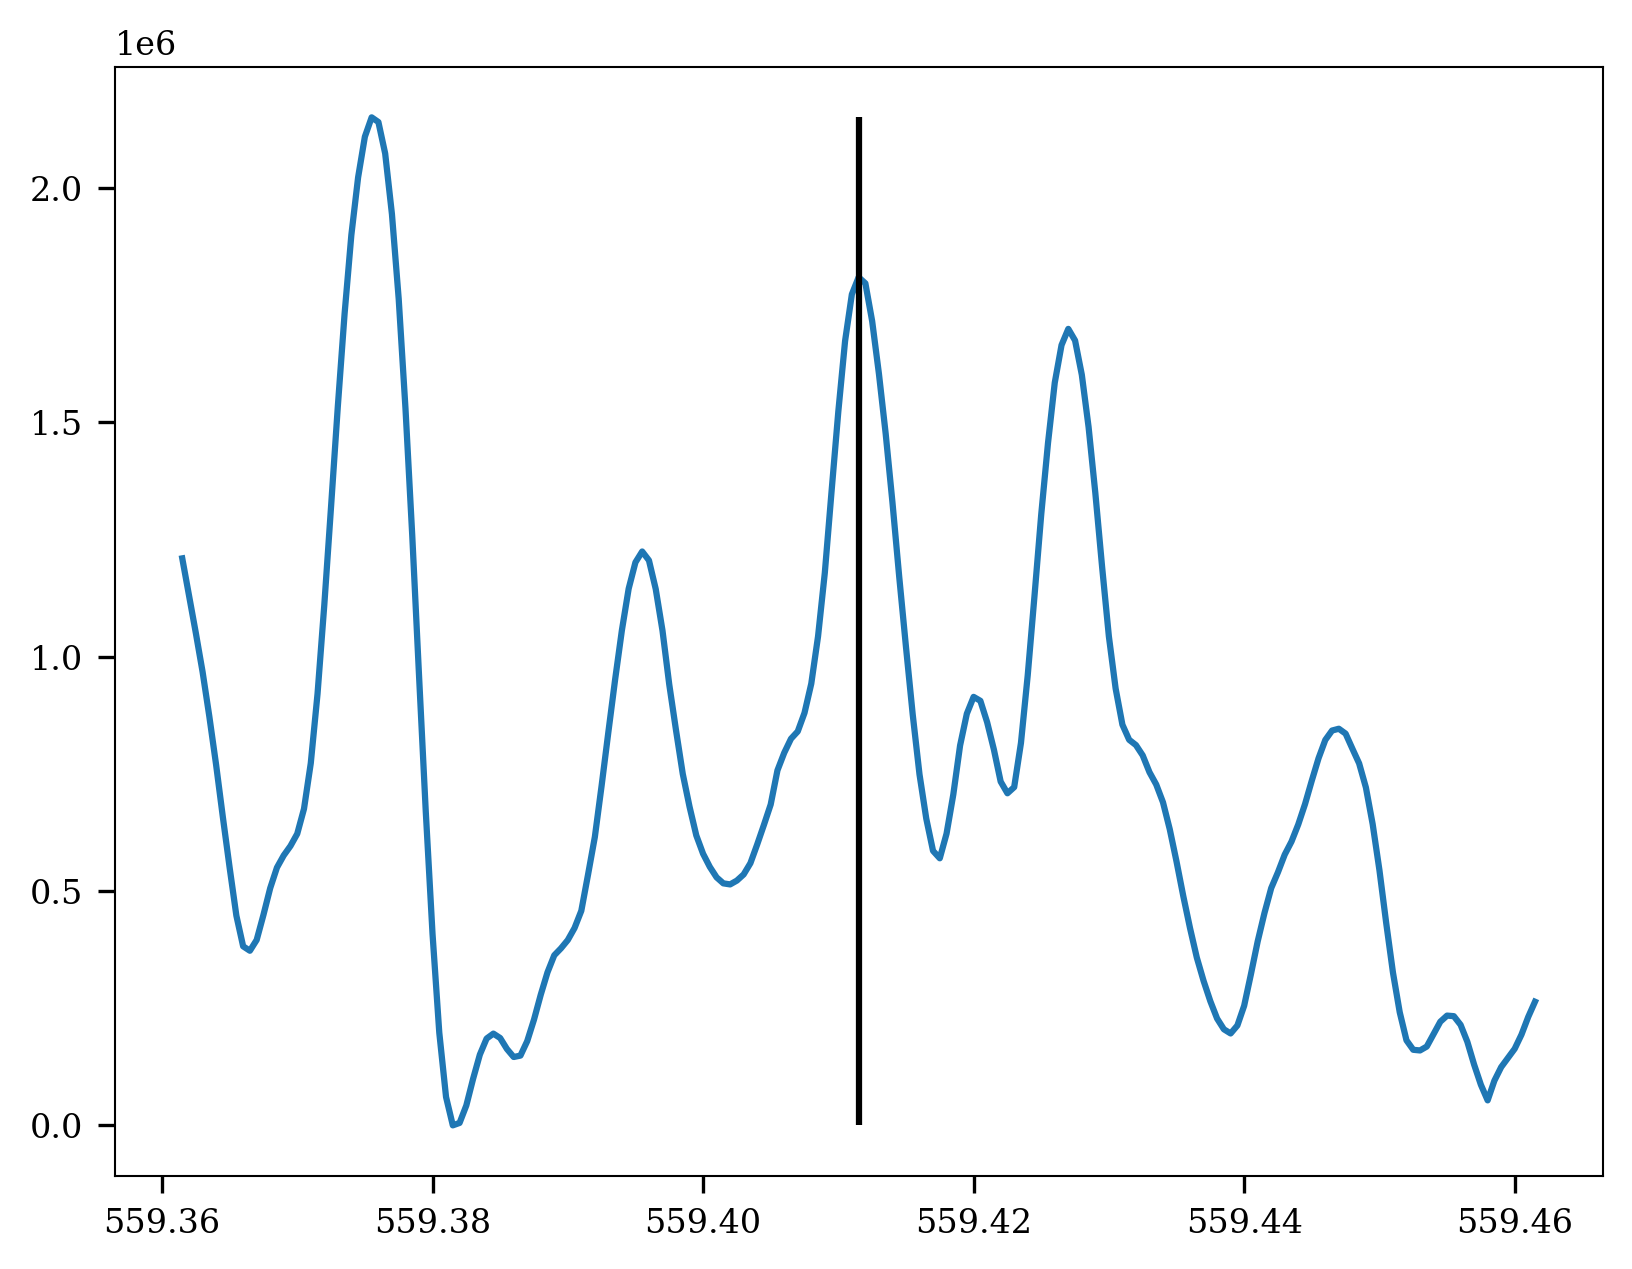

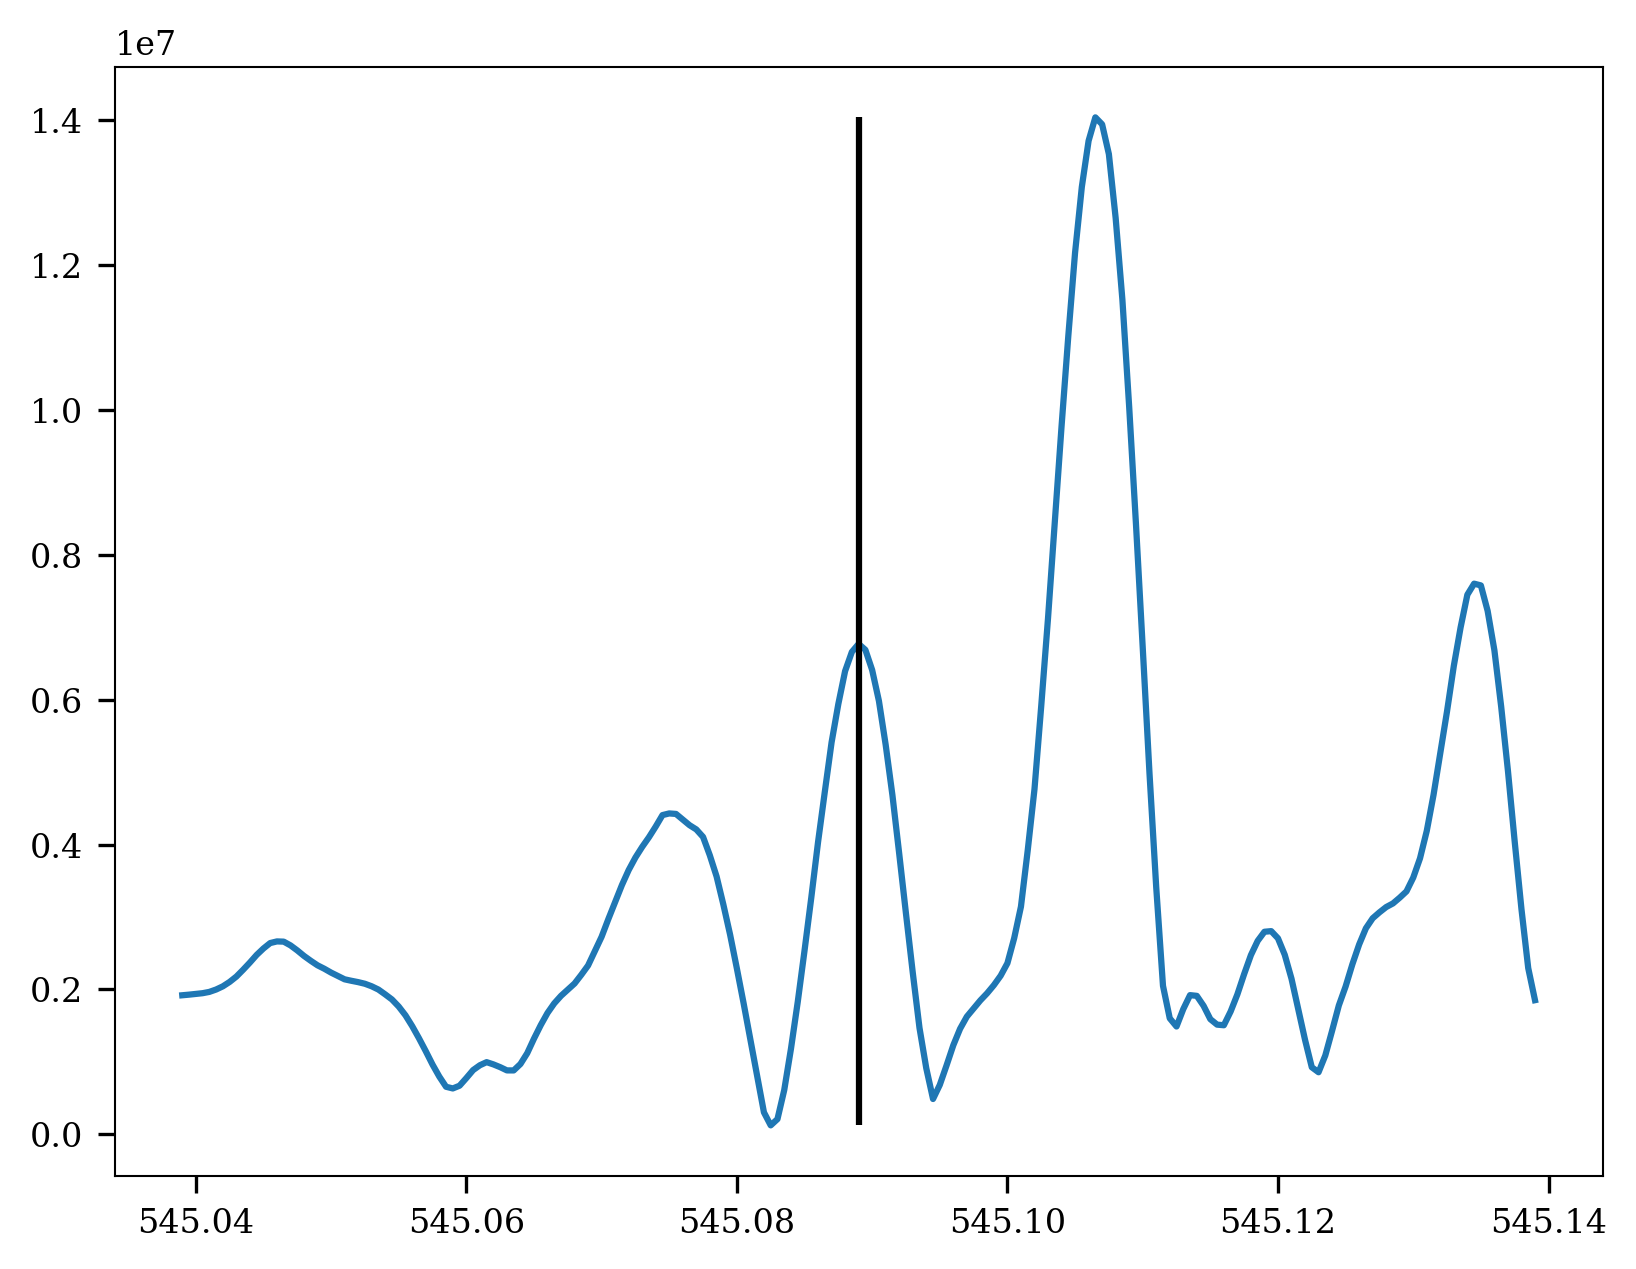

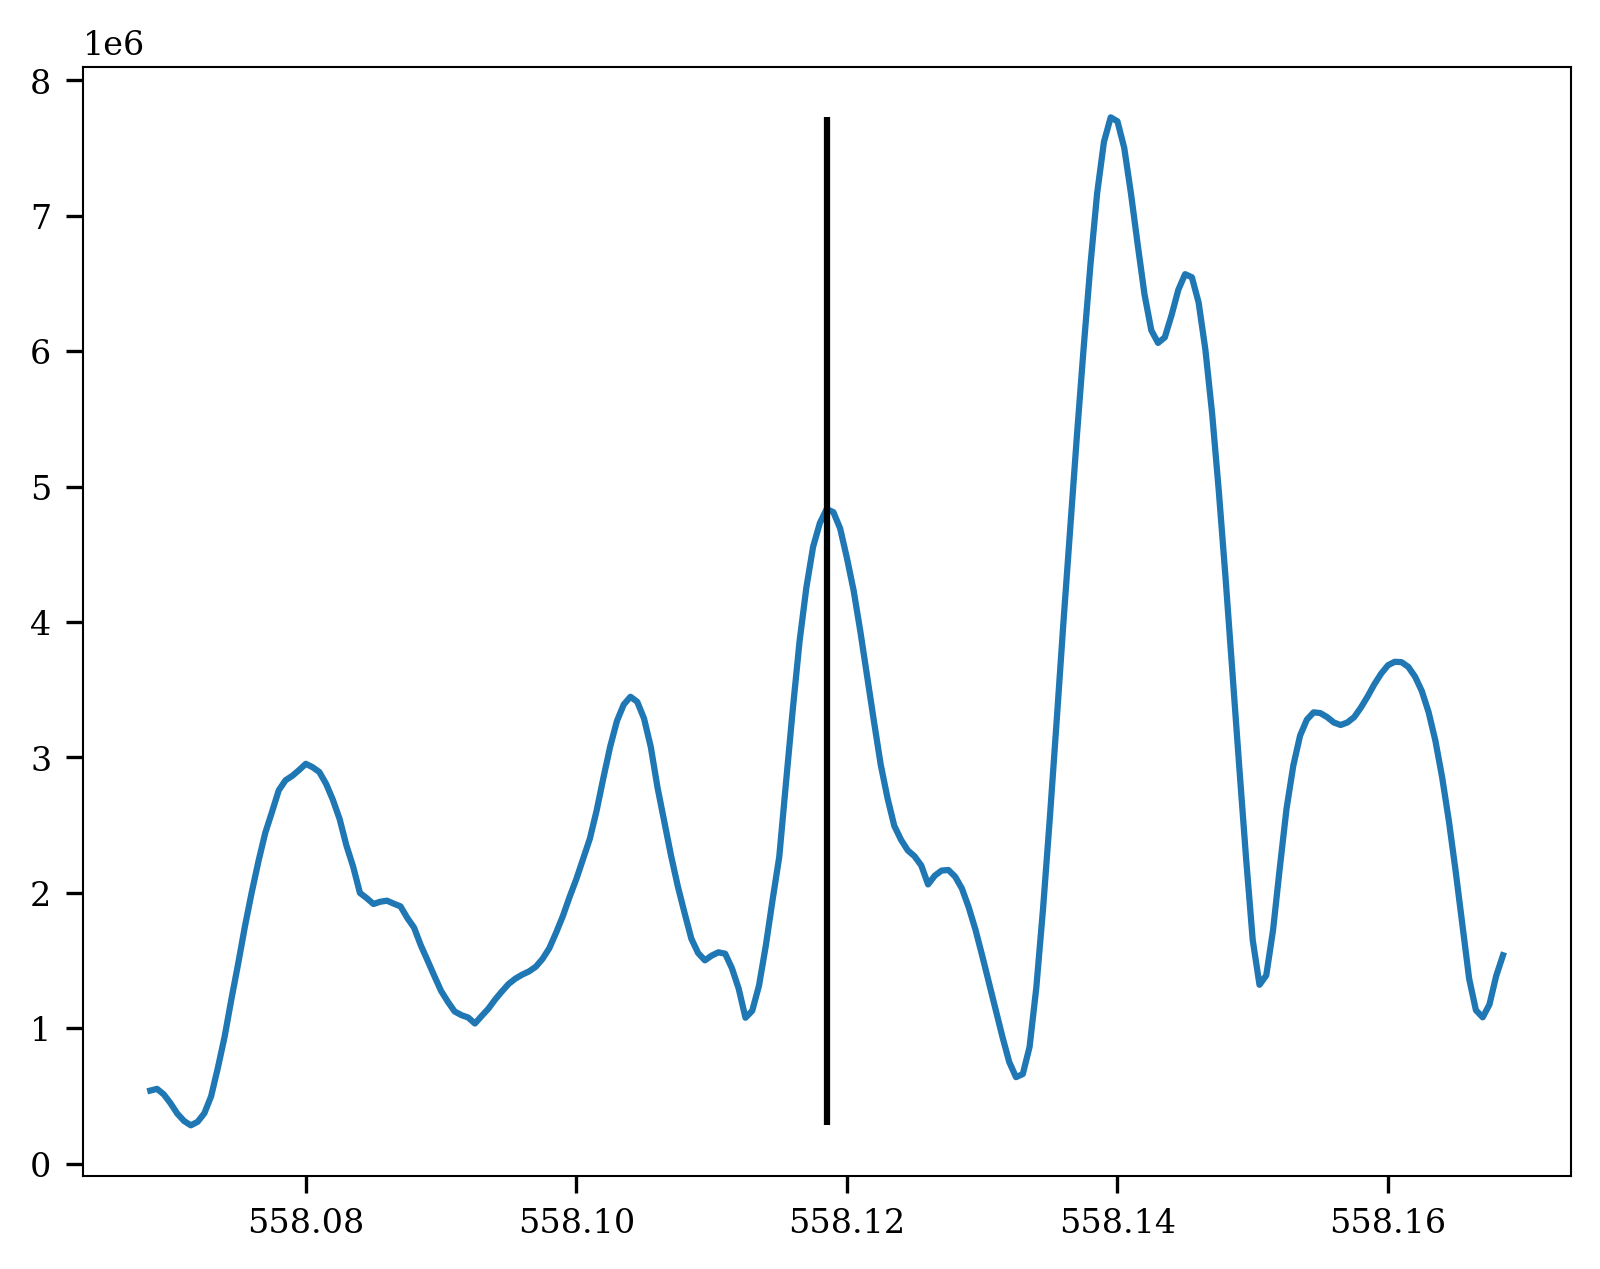

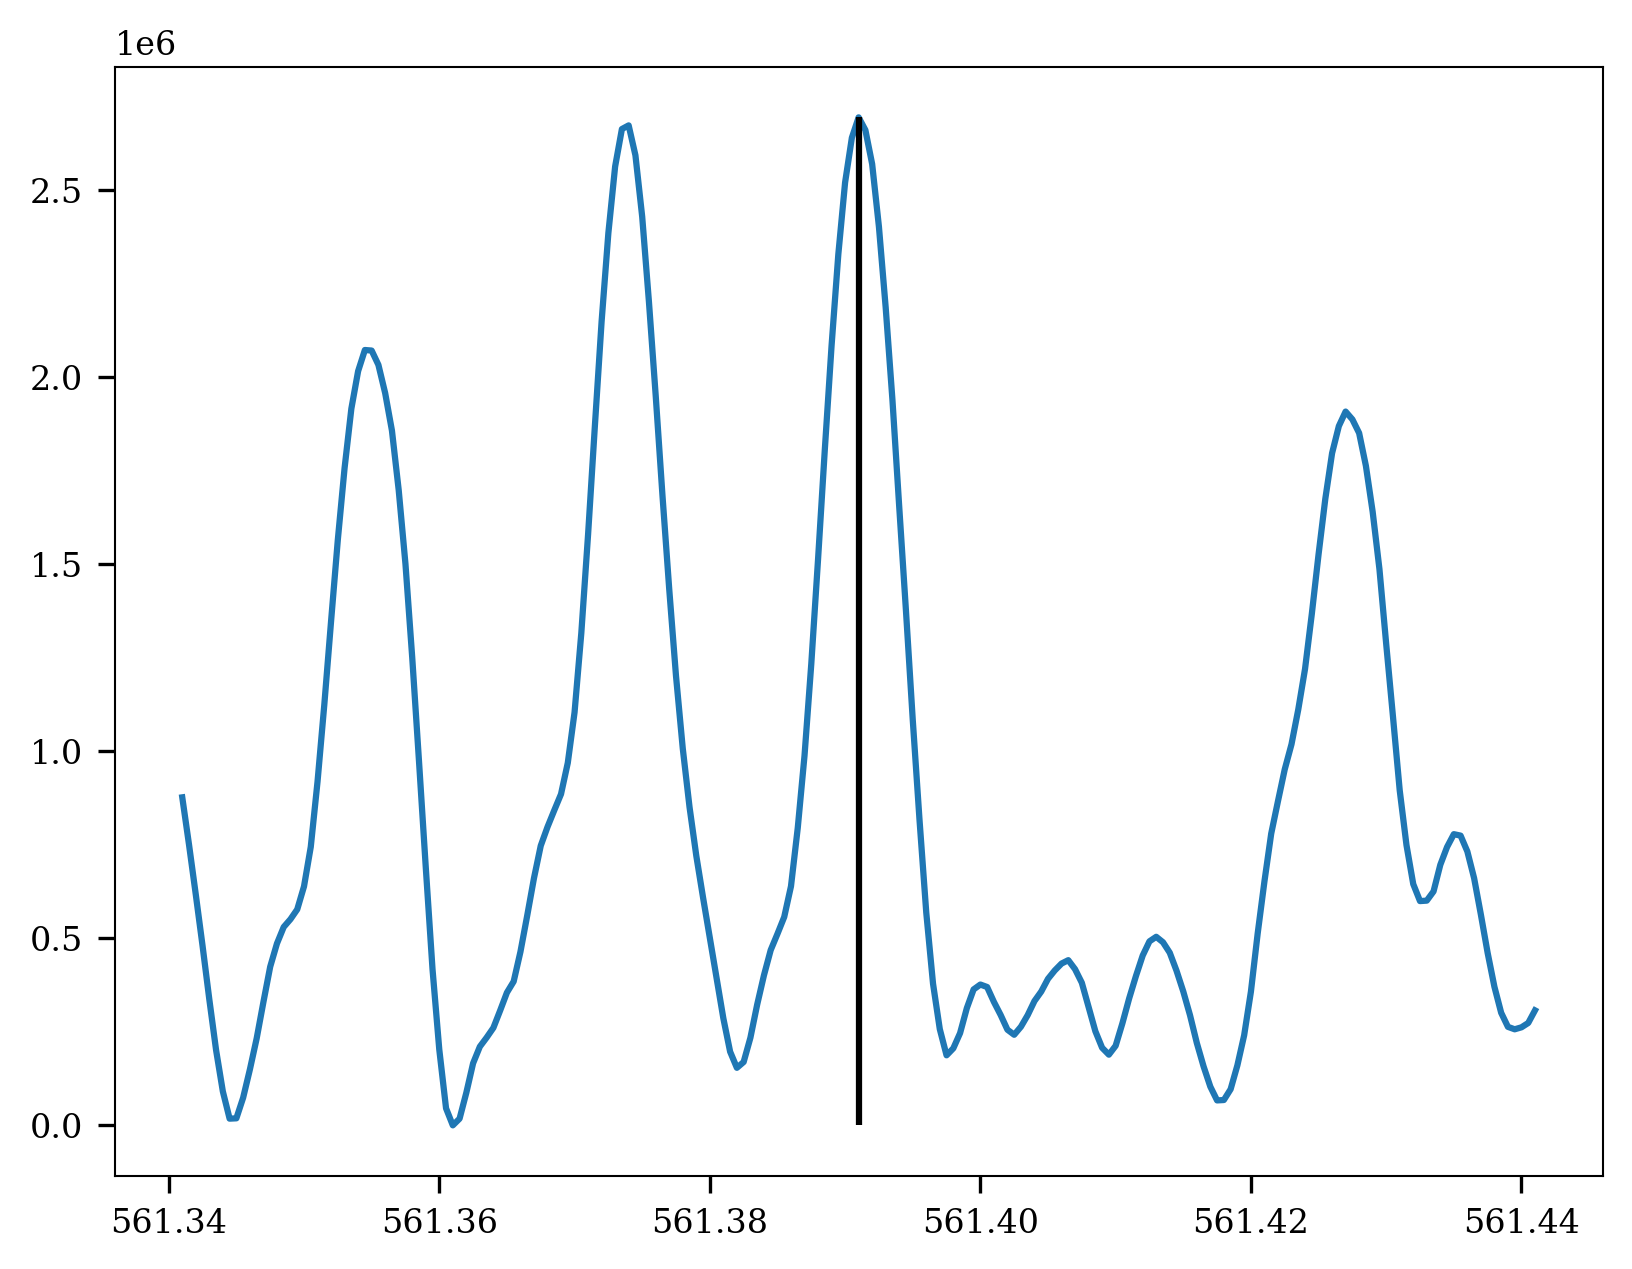

In [23]:
spec.set_peaks()
# use the same filter settings as above so that indices are the same
spec.filter_peaks(peaks_snr_threshold=SNR_threshold)
spec.filter_peaks(remove_sidepeaks=remove_sidepeaks)
for idx in [256 ,32, 238, 10, 210, 265]:
    center_mz = spec.mzs[spec._peaks[idx]]
    window_size = .1
    mask = (spec.mzs > center_mz - window_size / 2) & (spec.mzs < center_mz + window_size / 2)
    plt.plot(spec.mzs[mask], spec.intensities[mask])
    plt.vlines(center_mz, spec.intensities[mask].min(), spec.intensities[mask].max(), color='k')
    plt.show()

The peaks for which the estimation failed, are indeed not very sharp. This is partially due to the fairly low number of spectra in this toy example (noise is less likely to average out than for a full measurement). If you want to keep those peaks nonetheless, you can increase `sigma_max` although we only recommend doing this if you need any of the otherwise discarded peaks. 

The next steps are the same as in the targeted approach

#### Binning the spectra
Using our kernels, we can now estimate the compound abundances within each spectrum

In [24]:
spec.set_peaks()
spec.filter_peaks(SNR_threshold=SNR_threshold)
spec.filter_peaks(remove_sidepeaks=remove_sidepeaks)
spec.set_kernels(suppress_warnings=True)
spec.bin_spectra(reader)

INFO:root:Removing 0 peaks identified as side peaks
setting peak parameters: 100%|████████████████████████████████████████████████████| 1740/1740 [00:04<00:00, 378.85it/s]
INFO:root:keeping 1655 whitelisted out of 1740 peaks
binning spectra: 100%|███████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 1636.13it/s]


and turn it into a feature table

In [25]:
df = spec.set_feature_table()
df

544.0136      544.0651      544.0936      544.1094      544.1251  \
0    18077.848039  1.884650e+04  4.795035e+03  1.437019e+04  1.438850e+04   
1    16595.881747  3.613994e+04  1.026115e+04  2.547347e+04  1.459918e+04   
2    15673.474001  1.037734e+04  1.304760e+04  1.927416e+04  1.743450e+04   
3    17757.711667  6.676335e+04  2.242759e+04  2.022728e+04  7.549417e+04   
4    37611.621975  3.321113e+04  3.791849e+04  5.410437e+04  3.065912e+04   
..            ...           ...           ...           ...           ...   
67    2781.297843  4.428164e+03  6.279704e+03  3.434410e+04  2.772233e+04   
68    9243.072903  2.721569e+04  3.187256e+04  1.756644e+04  1.832534e+04   
69  441212.984683  1.719555e+06  4.115946e+06  1.002039e+06  6.899946e+06   
70    9959.976760  2.709100e+04  3.134424e+04  1.134231e+04  1.500053e+04   
71   31024.293291  3.870737e+04  1.545775e+04  2.673138e+04  2.525335e+04   

        544.1354      544.1517       544.1591       544.1631       544.1746  \
0   7.490181e+03  1.125734e+04    7494.212992    5888.218542   39605.263190   
1   4.682759e+03  3.205439e+04    9882.009981   18101.788055   13050.397607   
2   3.845205e+04  2.028055e+04   30435.137579   44242.524269   48211.564478   
3   6.454558e+04  7.355157e+04   54187.126038   72103.508472   33870.790323   
4   6.411517e+04  1.541373e+04   29458.638933   28388.512526    9505.433301   
..           ...           ...            ...            ...            ...   
67  2.247160e+04  1.483405e+04   12488.206876   27539.481012   56424.273730   
68  4.791928e+04  1.662569e+04   21120.385801    6659.343694   21772.753490   
69  1.054813e+06  6.245052e+06  798271.101710  230432.859721  297496.109721   
70  5.004393e+04  5.416457e+03   19533.649985   45281.637135   25273.194731   
71  3.718276e+04  2.270219e+04   23450.390124   17460.204274   39904.581138   

    ...       563.9334      563.9436      563.9496       563.9656  \
0   ...   25942.070692  31749.858411   5673.382213   11052.449682   
1   ...   11937.544128  10239.360970  29581.307040   21028.424814   
2   ...   12937.544391  14394.964266  31075.254502   16635.080101   
3   ...   21878.040399  33189.574610  38242.624218   10306.877580   
4   ...   28154.665042  25503.513441  26939.760759   33684.742090   
..  ...            ...           ...           ...            ...   
67  ...    9391.312331  15969.884375  11127.124362    4364.717402   
68  ...   14851.685145  33627.566011  23368.672063   13599.965527   
69  ...  108444.325027  71877.872771  24213.303253  193051.736665   
70  ...   21195.500505   9345.577756  33165.617530   51974.170892   
71  ...    7231.213836  12450.810656   5746.289008   15441.863413   

         563.9806       563.9916    tic_window  R   x   y  
0     4112.936763   30127.977973  8.023143e+04  0  82  54  
1    20931.183045    4555.486444  7.881567e+04  0  83  54  
2    30373.365117   21841.315284  8.267259e+04  0  84  54  
3    13985.992172   11737.750723  1.145312e+05  0  85  54  
4    12174.938213   16517.124188  1.415370e+05  0  77  55  
..            ...            ...           ... ..  ..  ..  
67   22634.634308   18361.798848  9.028226e+04  0  75  68  
68   35821.165600   35998.625744  1.278687e+05  0  76  68  
69  113442.568615  116420.550344  2.468518e+06  0  77  68  
70   23387.775622   20320.835412  9.858896e+04  0  76  69  
71   20586.943414   17727.106968  8.793757e+04  0  77  69  

[72 rows x 1659 columns]

### Filtering intensities
This feature table may contain a lot of intensities that are below the noise level. It may be desirable to set those intensities to zero. Let's first look at how our ion image looks now and then do the filtering

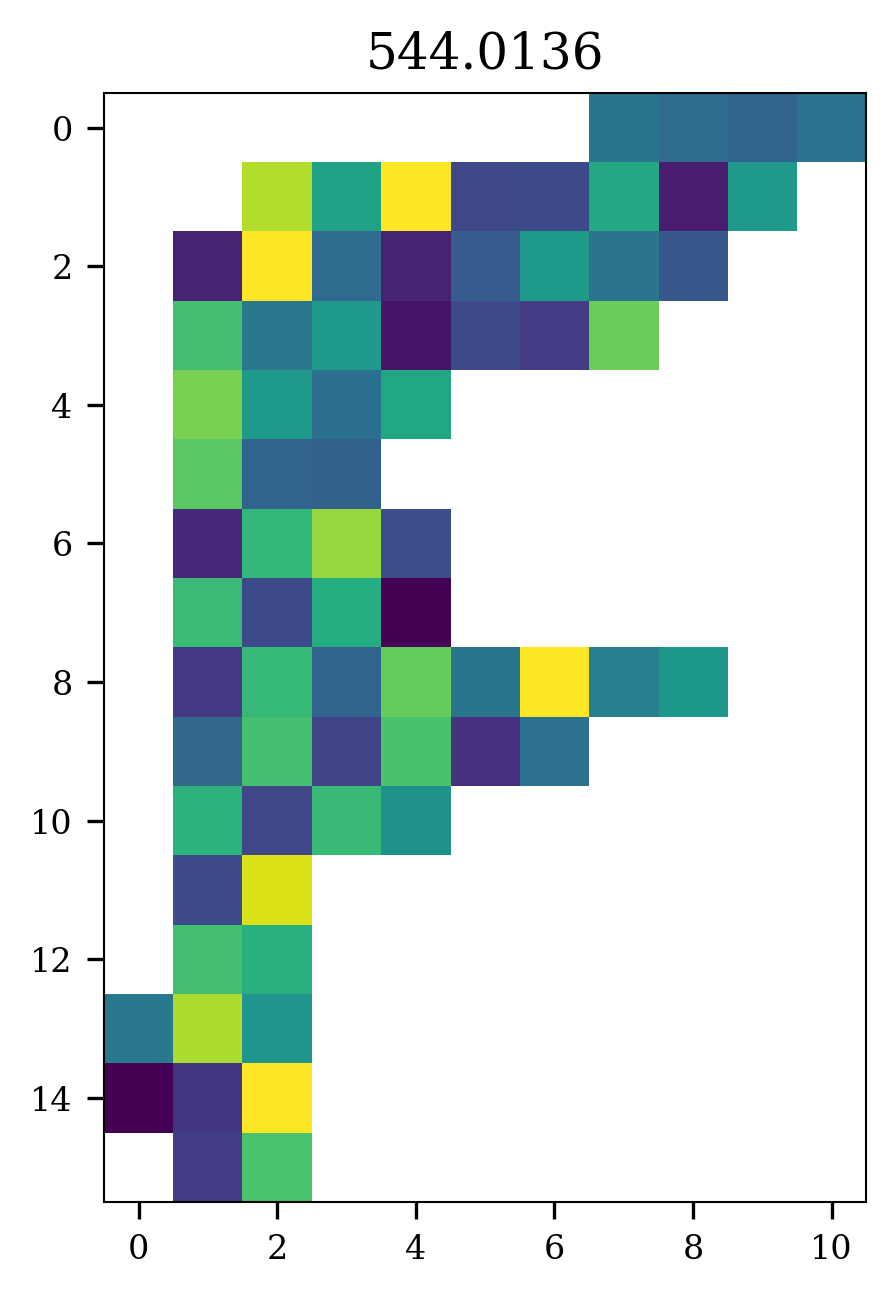

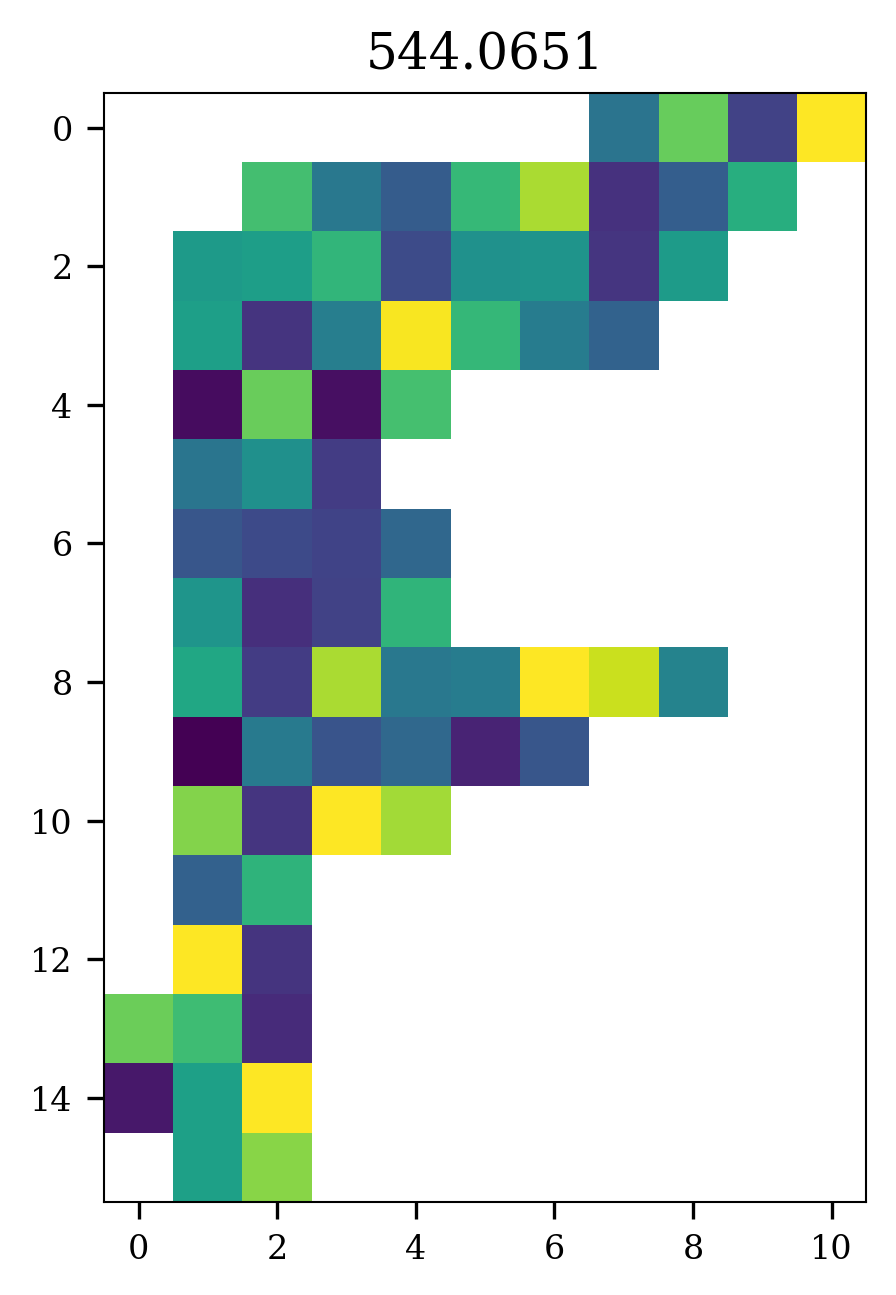

In [26]:
cols = spec.feature_table.columns[:2]
for col in cols:
    img = spec.feature_table.pivot(index='y', columns='x', values=col)
    clip = np.nanquantile(img, .95)
    img[img > clip] = clip
    plt.imshow(img)
    plt.title(col)
    plt.show()

Now let's do the filtering with an SNR of 2

In [27]:
_ = spec.filter_line_spectra(SNR_threshold=8)

and look at the ion images again

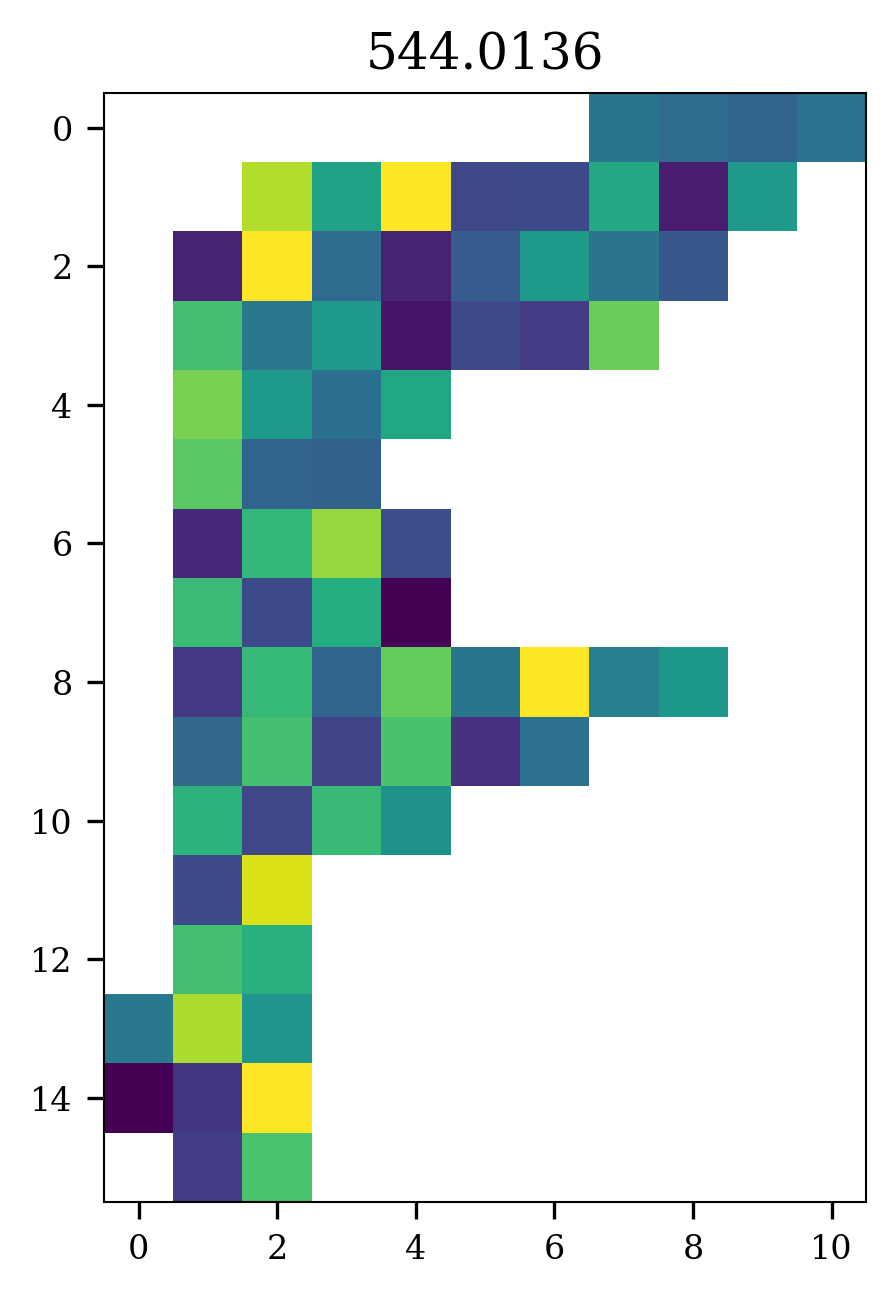

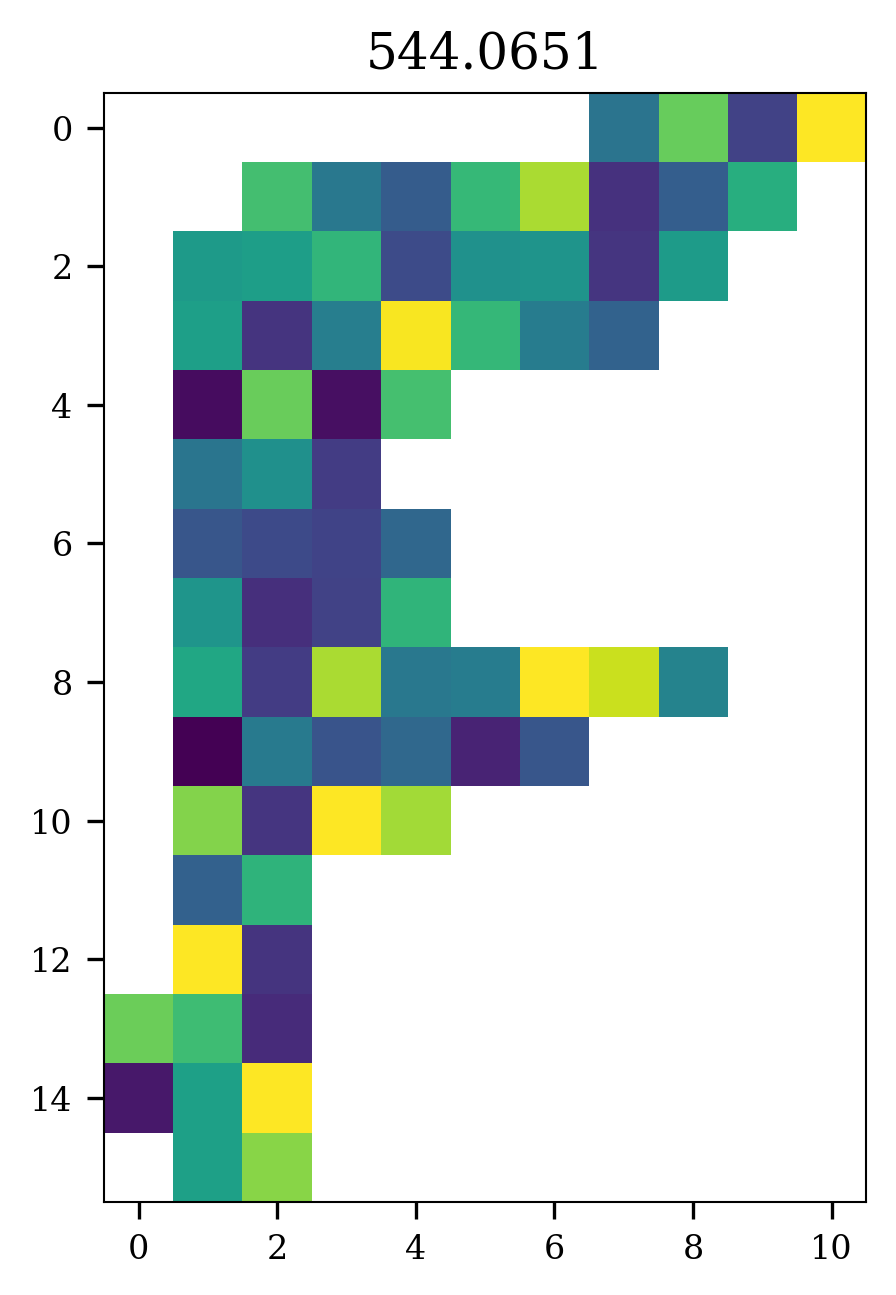

In [28]:
cols = spec.feature_table.columns[:2]
for col in cols:
    img = spec.feature_table.pivot(index='y', columns='x', values=col)
    clip = np.nanquantile(img, .95)
    img[img > clip] = clip
    plt.imshow(img)
    plt.title(col)
    plt.show()

Unfortunately, due to the low number of spectra the noise-level estimation is not working very well here.

## Shortcut
As in the previous section, we don't have to deal with all those steps. All we need to do is to specify the parameters and use the `ProjectMSI` class. To recapitulate, those parameters were
* `window_size`: the size of the minimum filter for subtracting the baseline (will be determined automatically if not provided)
* `calibrants_mz`: masses of calibrants to be used for calibrating spectra (will be taken from a list of known calibrants if not provided)
* `prominence`: minimum peak prominence for peaks to be considered relevant in the final feature table (default is 0.1, only untargeted approach)
* `targets`: list of target compounds (only targeted approach)
* `SNR_threshold`: required SNR value for intensities of compounds to be set to 0 (default is no filtering)

INFO:maspim.project.main:loaded spectra with tag=None
INFO:maspim.util.convenience:loaded Spectra with keys {'_kernel_params', '_binning_by', '_delta_mz', '_calibration_settings', '_limits', '_feature_table', '_noise_level_subtracted', '_calibration_parameters', '_peaks', '_indices', '_peak_setting_parameters', '_peaks_is_side_peak', '_intensities', '_mzs', '_noise_level_parameters', '_noise_level', '_line_spectra', '_tic', '_kernel_shape', '_peak_properties', '_peaks_SNR'}
INFO:maspim.project.main:Continuing processing of spectra object
INFO:maspim.project.main:spectra object does not have peaks
INFO:maspim.project.main:spectra object does not have kernels
setting peak parameters:  13%|██████▉                                              | 226/1740 [00:00<00:04, 369.18it/s]C:\Users\Yannick Zander\Downloads\WPy64-31241\python-3.12.4.amd64\Lib\site-packages\maspim\exporting\from_mcf\spectrum.py:1484: OptimizeWarning: Covariance of the parameters could not be estimated
  params, *_ = cur

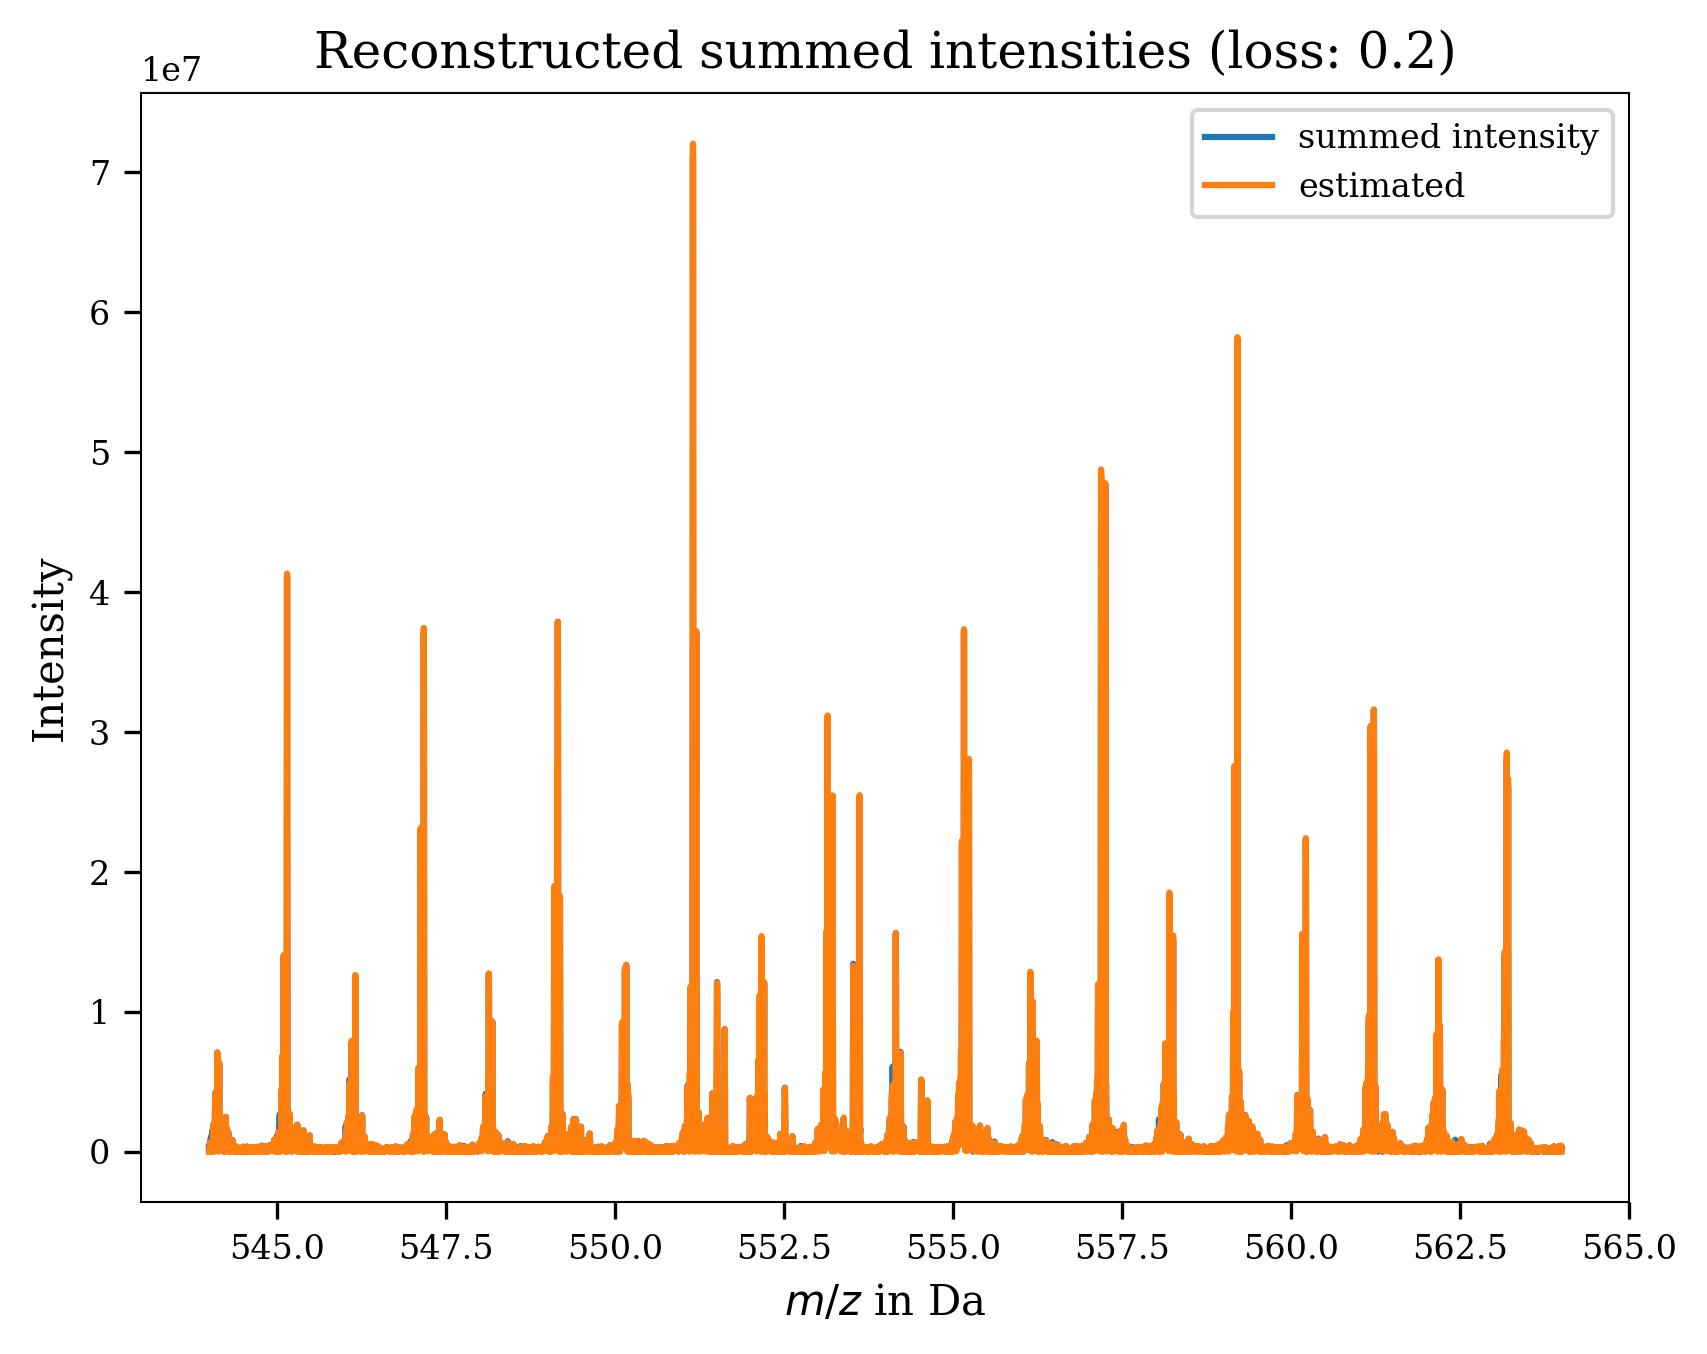

INFO:maspim.util.convenience:saving image object with {'_kernel_params', '_binning_by', '_delta_mz', '_calibration_settings', '_limits', '_noise_level_subtracted', '_calibration_parameters', '_peaks', '_indices', '_peak_setting_parameters', '_peaks_is_side_peak', '_intensities', '_mzs', '_noise_level_parameters', '_noise_level', '_line_spectra', '_tic', '_kernel_shape', '_peak_properties', '_peaks_SNR'} to C:\Users\Yannick Zander\Downloads\maspim workshop\data\small example\small example.d


path_folder: C:\Users\Yannick Zander\Downloads\maspim workshop\data\small example
d_folder: small example.d
_delta_mz: 0.0001
_kernel_params: Numpy array of type float64, with shape (1655, 3)
_binning_by: height
_calibration_settings: calibrants: [551.4435, 551.5162, 553.5319, 555.2367, 557.2523, 559.4274]
                       search_range: 0.01
                       calib_snr_threshold: 4
                       max_degree: 1
                       presences calibrants: {551.4435: 0.4166666666666667, 551.5162: 0.6388888888888888, 553.5319: 0.6805555555555556, 555.2367: 0.8611111111111112, 557.2523: 0.9027777777777778, 559.4274: 0.1388888888888889}
_limits: Numpy array of type float64, with shape (2,)
_feature_table: Pandas DataFrame with columns [544.0136, 544.0651, 544.0936, 544.1094, 544.1251, 544.1354, 544.1517, 544.1591, 544.1631, 544.1746, ...], indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...] and shape (72, 1659)
_noise_level_subtracted: True
_calibration_parameters: Numpy array of

In [29]:
%matplotlib inline

from maspim import get_project
from user_params import path_folder_test_data

path_folder = path_folder_test_data

project = get_project(is_MSI=True, path_folder=path_folder)
project.require_spectra(plts=True, suppress_warnings=True, search_range=10e-3, tolerances=5e-3)

and visualization is more comfortable as well

Fetching intensities from Spectra: 100%|█████████████████████████████████████████████| 72/72 [00:00<00:00, 2287.13it/s]
INFO:maspim.data.helpers:did not find x_ROI in Index(['553.528', 'R', 'x', 'y'], dtype='object'), attempting to find "x" and "y"
INFO:maspim.data.helpers:clipping values to 95% percentile
INFO:maspim.data.helpers:clipping values to 0% percentile


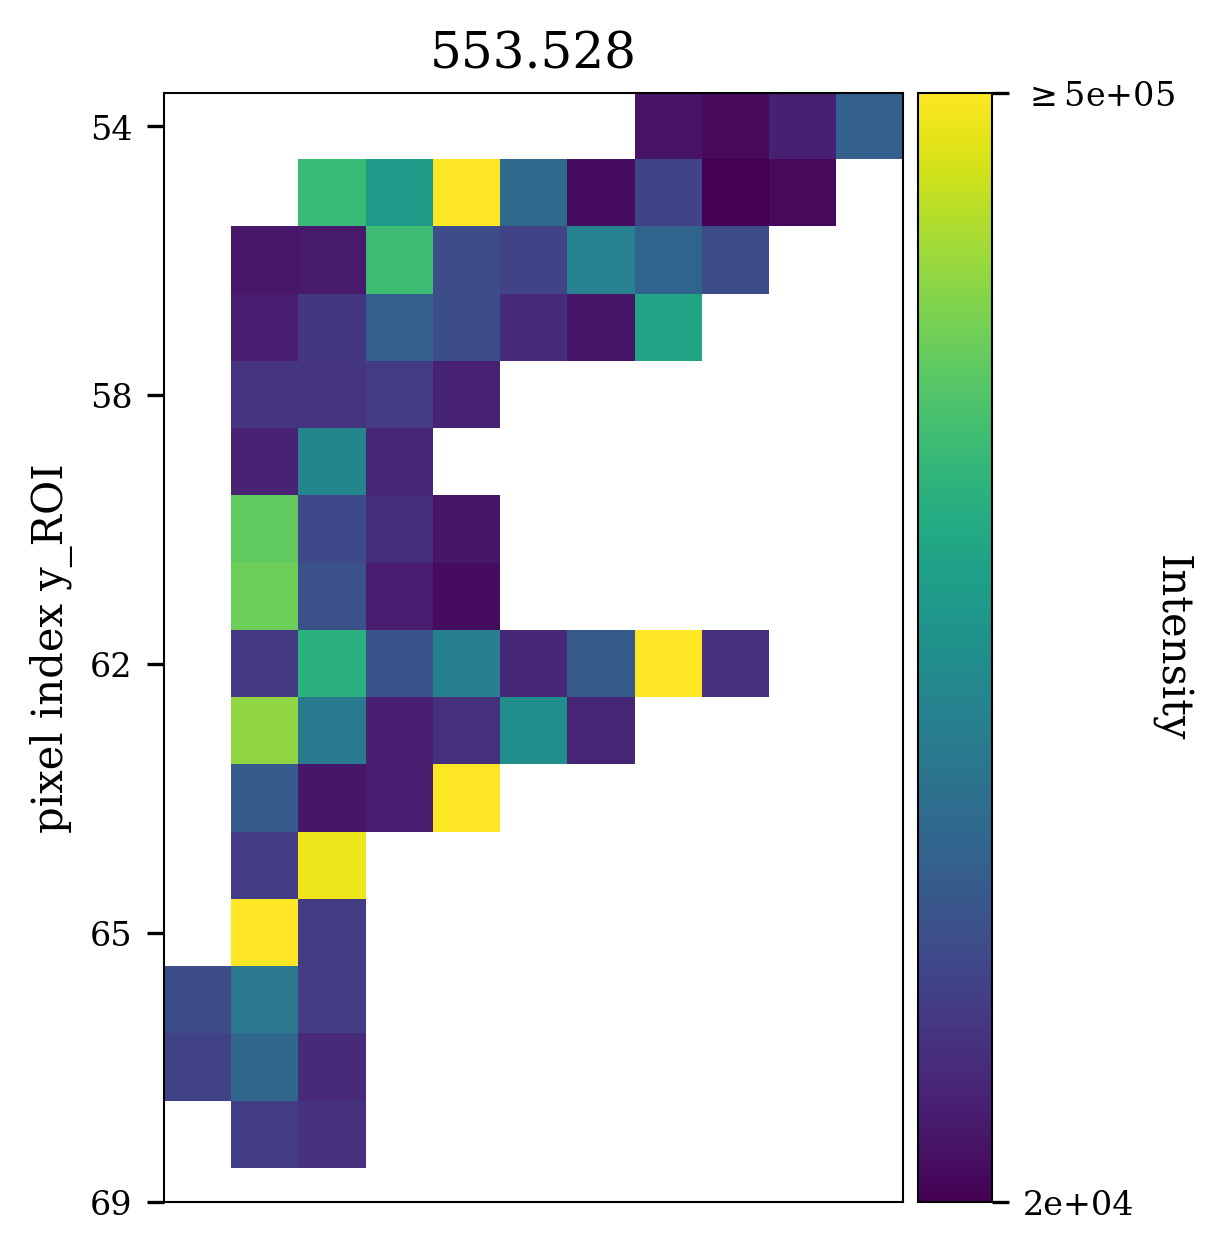

In [30]:
from maspim.res.compound_masses import mC37_2

project.plot_comp(mC37_2, 'spectra', tolerance=5e-3)

## Final remarks
Some functions take more parameters than discussed here. If you did not find what you were looking for here, consider checking out the documentation. 

In general, we'd recommend using the *shortcut* way, but checking if results meet your expectations is still highly recommended (the `plts=True` parameter can be of help here). Also, as a final step let's take a look at the differences between the actual spectra and the extracted information (termed *reconstruction loss*). 

Set the losses and plot them

Setting losses: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 78.63it/s]


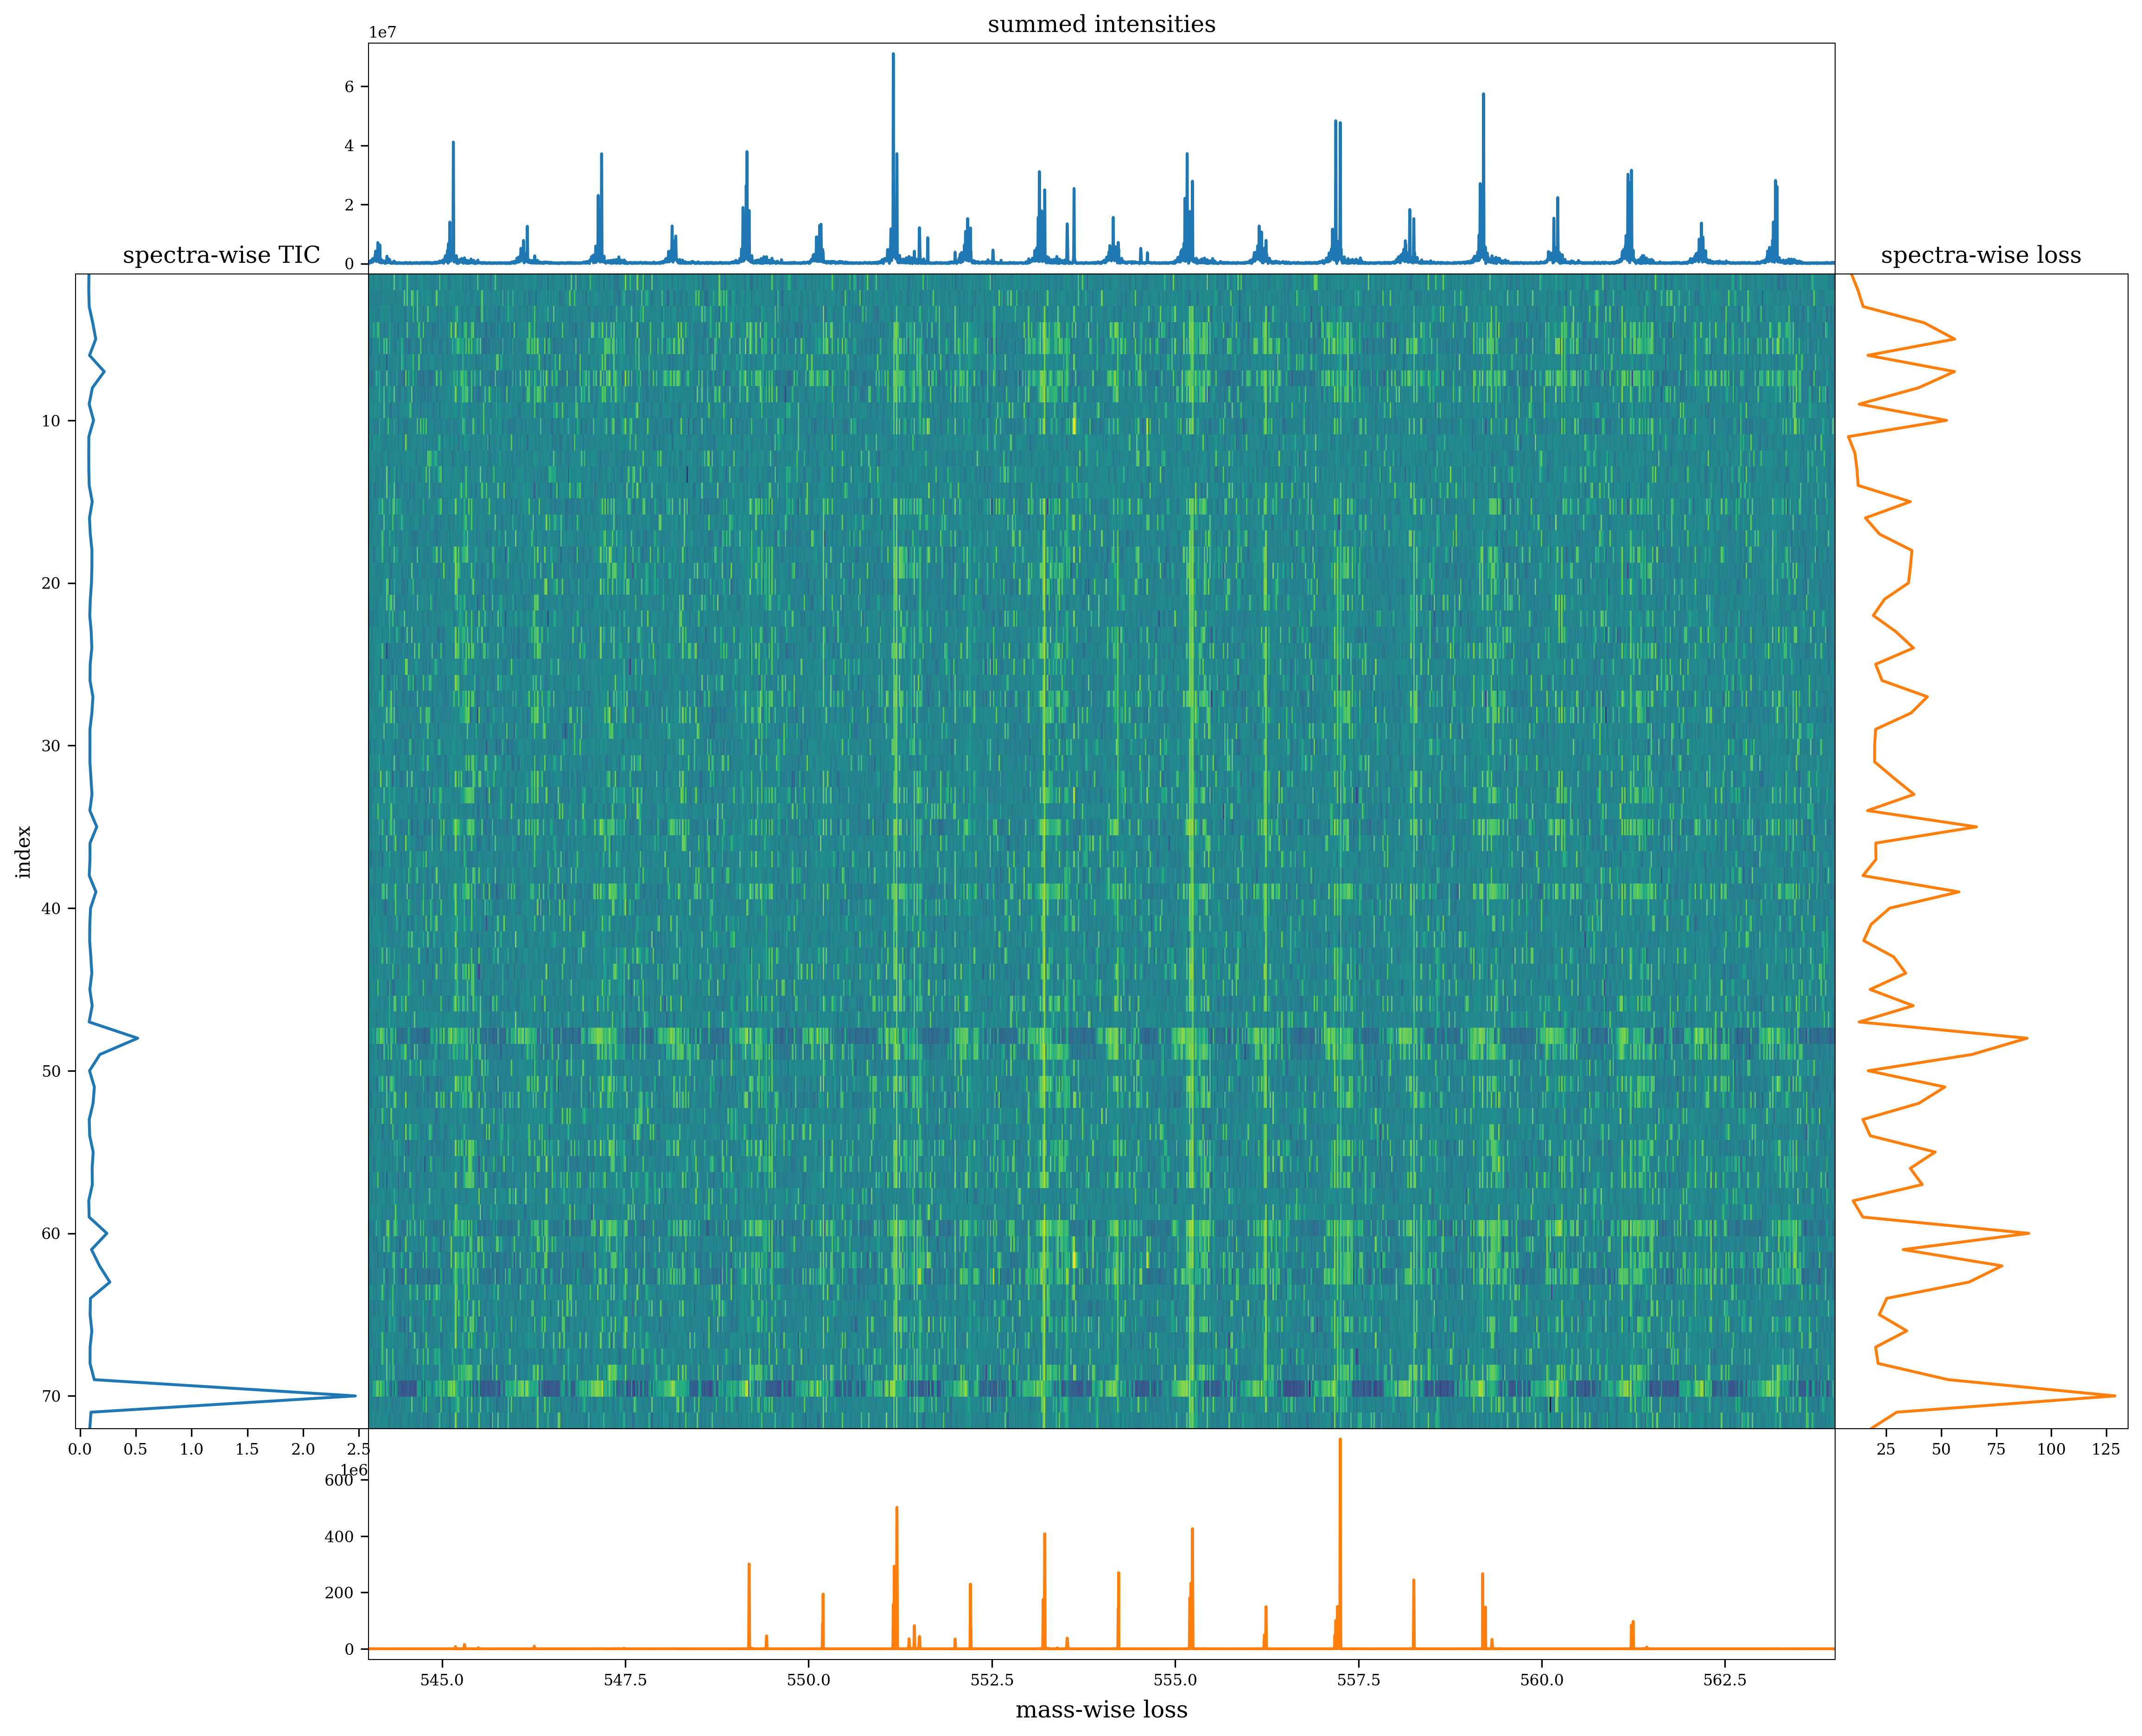

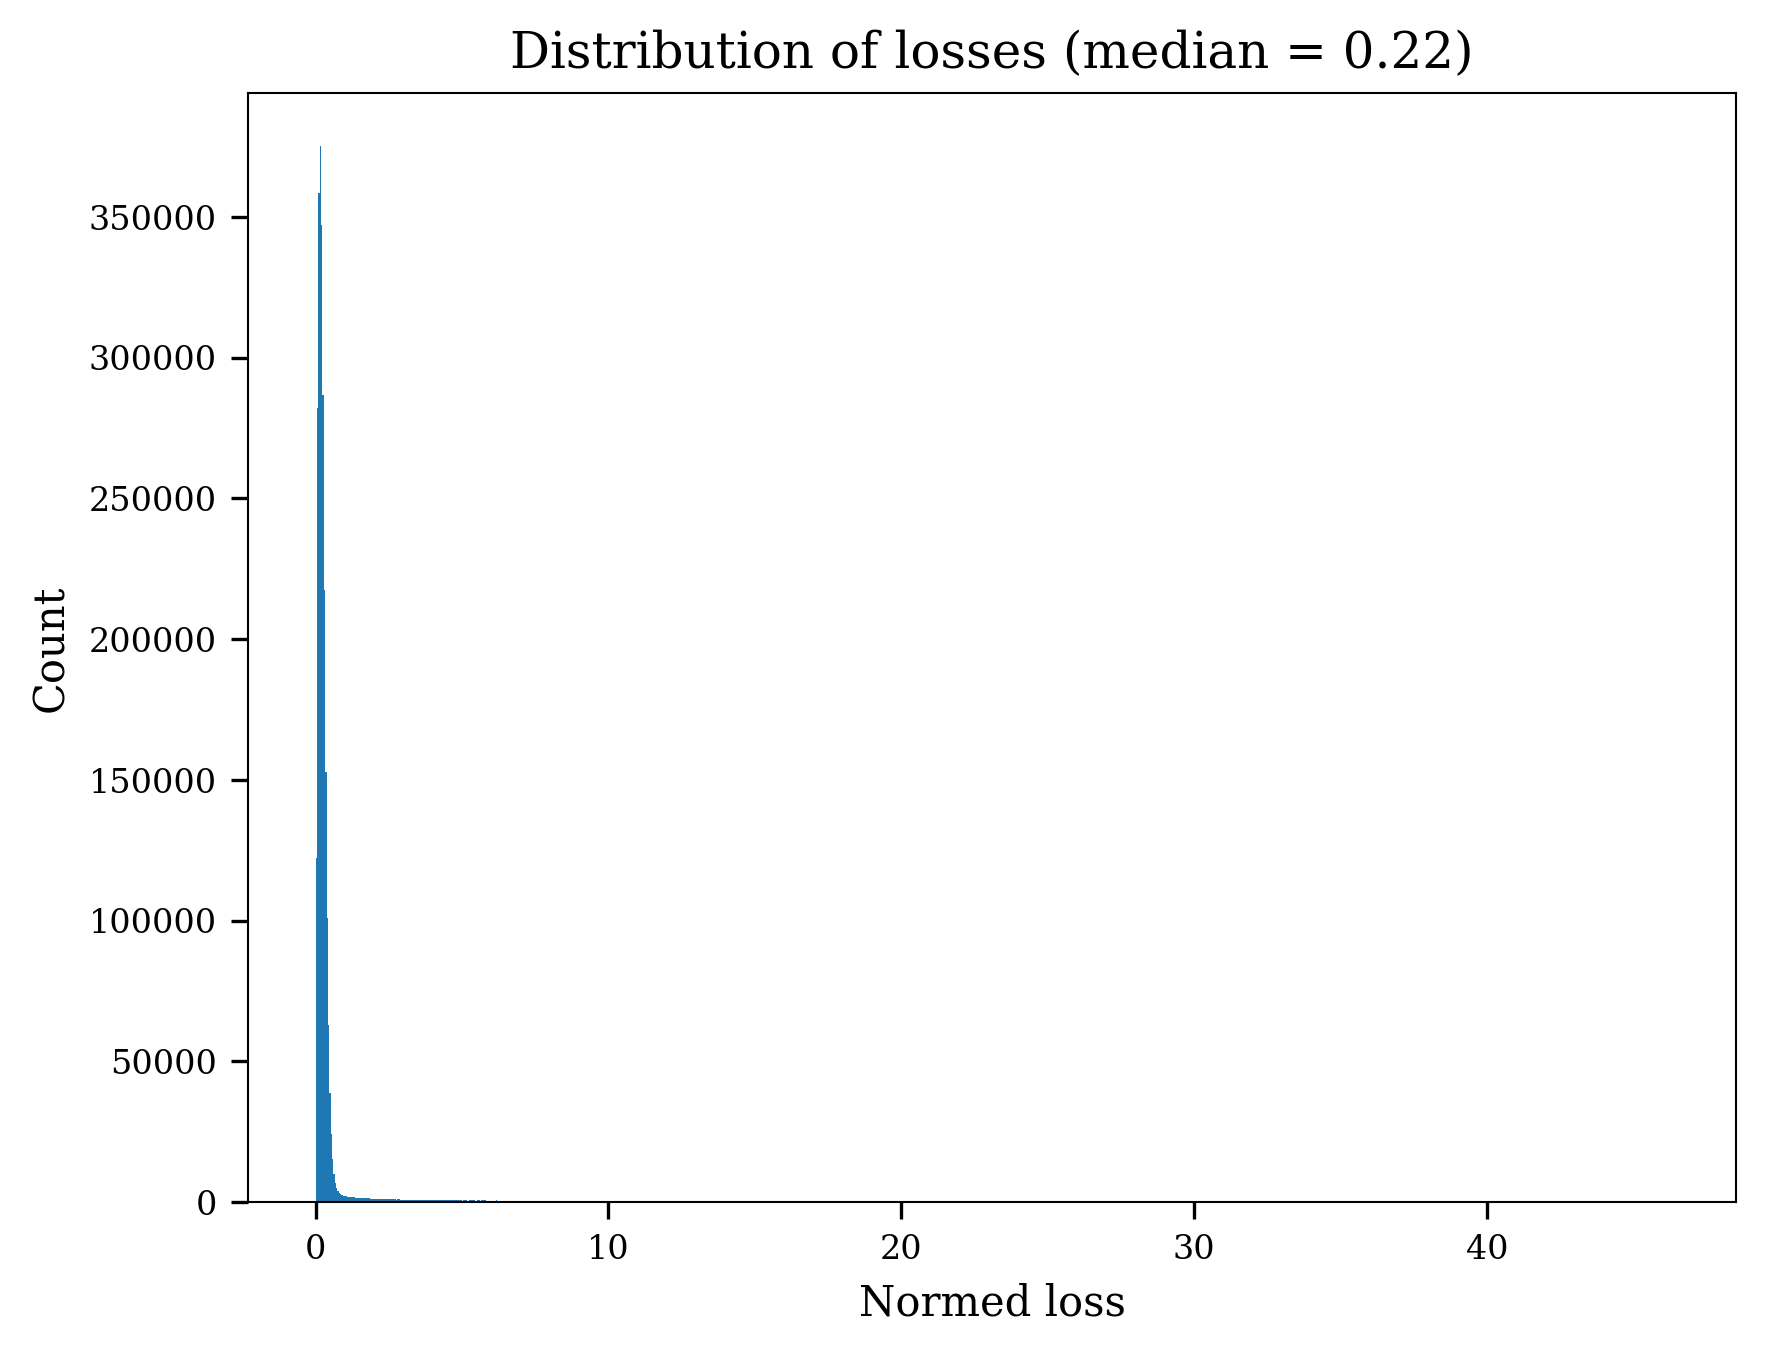

In [31]:
project.spectra.set_reconstruction_losses(reader=project.get_hdf_reader())
project.spectra.plot_losses()

This figure is a bit busy, but let's look at each panel individually:
* The curve at the top is the summed intensities.
* The curve at the left shows the total ion counts (abbreviated TIC, integral of intensities) for each spectrum.
* The heatmap in the center are point-wise losses, so the difference between the original and reconstructed spectra, normalized to the TIC on a log scale.
* The curve on the right is the spectra-wise loss, so the integral of losses for each spectrum.
* The panel at the bottom shows the mass-wise losses, which is here taken as the median loss for each mass across spectra.

We can see that one spectrum has a much higher TIC and this also corresponds to the highest loss. Furthermore, losses are higher around peaks. Binning is always a trade off between accuracy and generality: it would be possible to achieve lower losses by fitting even more kernels, but the usefulness of small peaks is limited. 

Notice, however, that losses are much higher if we perform no noise-filtering:

INFO:maspim.util.convenience:loaded Spectra with keys {'_kernel_params', '_binning_by', '_delta_mz', '_calibration_settings', '_limits', '_noise_level_subtracted', '_calibration_parameters', '_peaks', '_indices', '_peak_setting_parameters', '_peaks_is_side_peak', '_intensities', '_mzs', '_noise_level_parameters', '_noise_level', '_line_spectra', '_tic', '_kernel_shape', '_peak_properties', '_peaks_SNR'}
setting peak parameters:  13%|██████▉                                              | 228/1740 [00:00<00:04, 373.05it/s]C:\Users\Yannick Zander\Downloads\WPy64-31241\python-3.12.4.amd64\Lib\site-packages\maspim\exporting\from_mcf\spectrum.py:1484: OptimizeWarning: Covariance of the parameters could not be estimated
  params, *_ = curve_fit(
setting peak parameters: 100%|████████████████████████████████████████████████████| 1740/1740 [00:04<00:00, 378.05it/s]
INFO:root:keeping 1655 whitelisted out of 1740 peaks
Setting losses: 100%|█████████████████████████████████████████████████████████

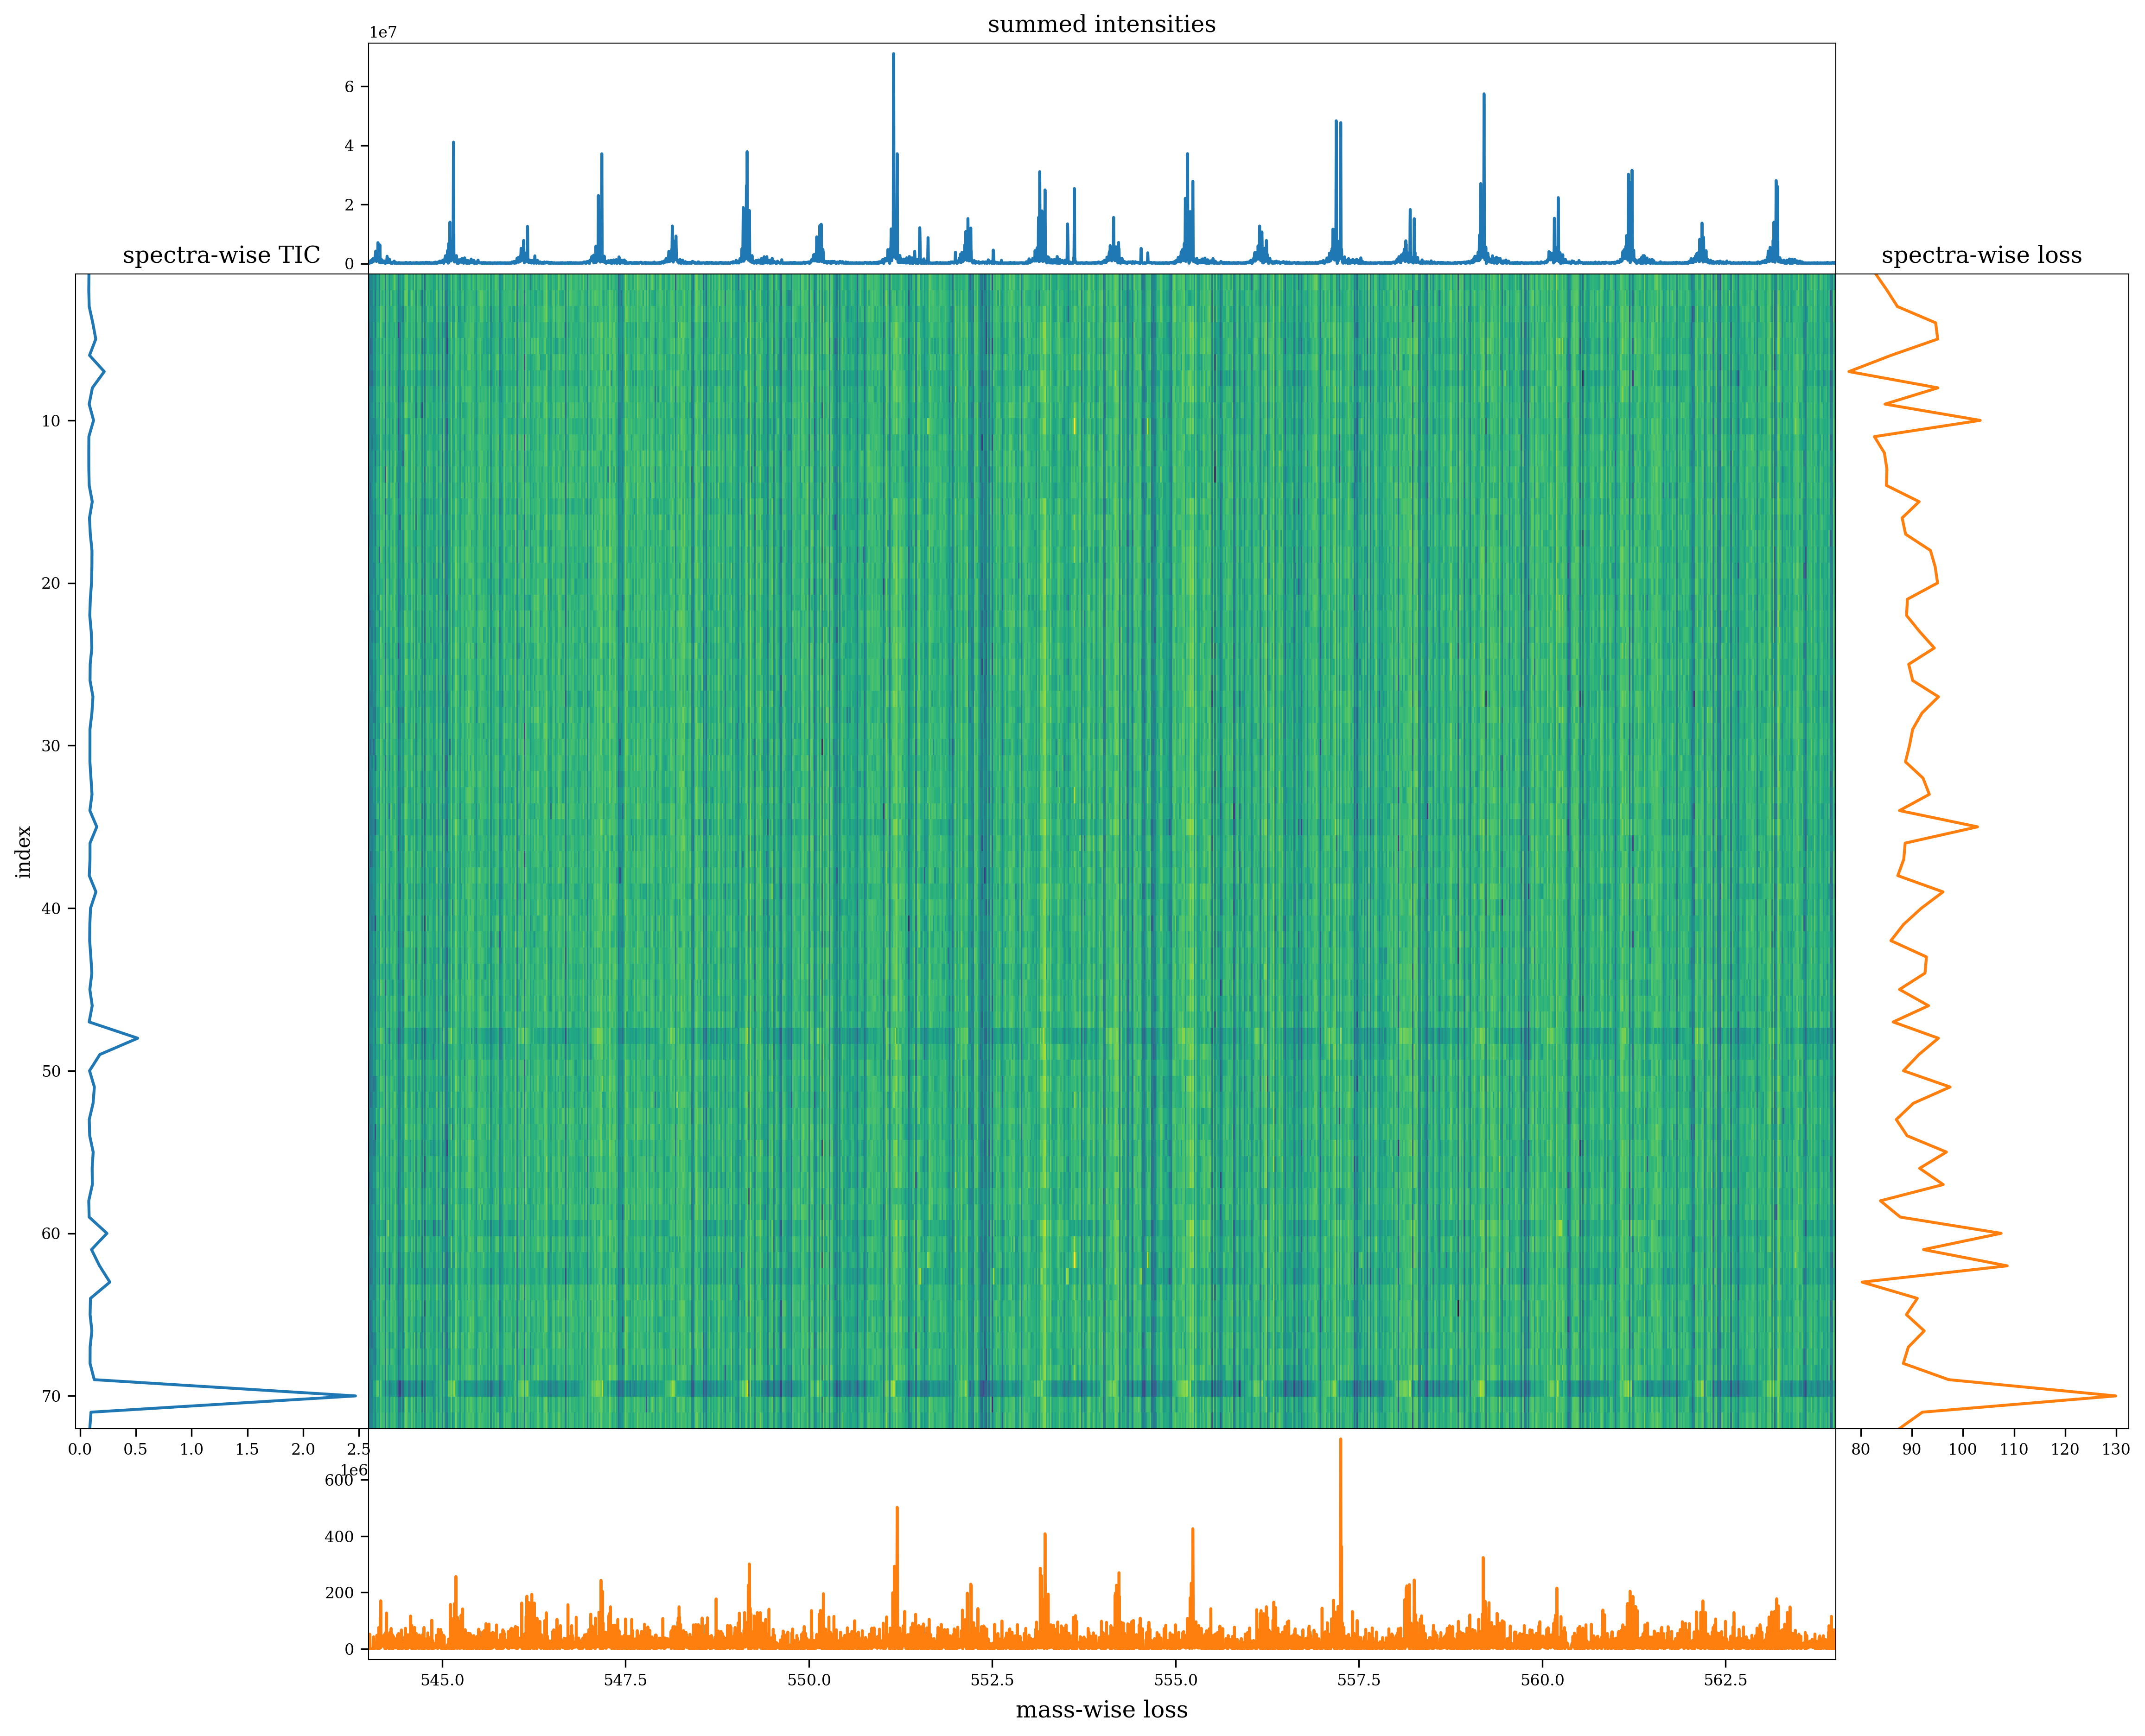

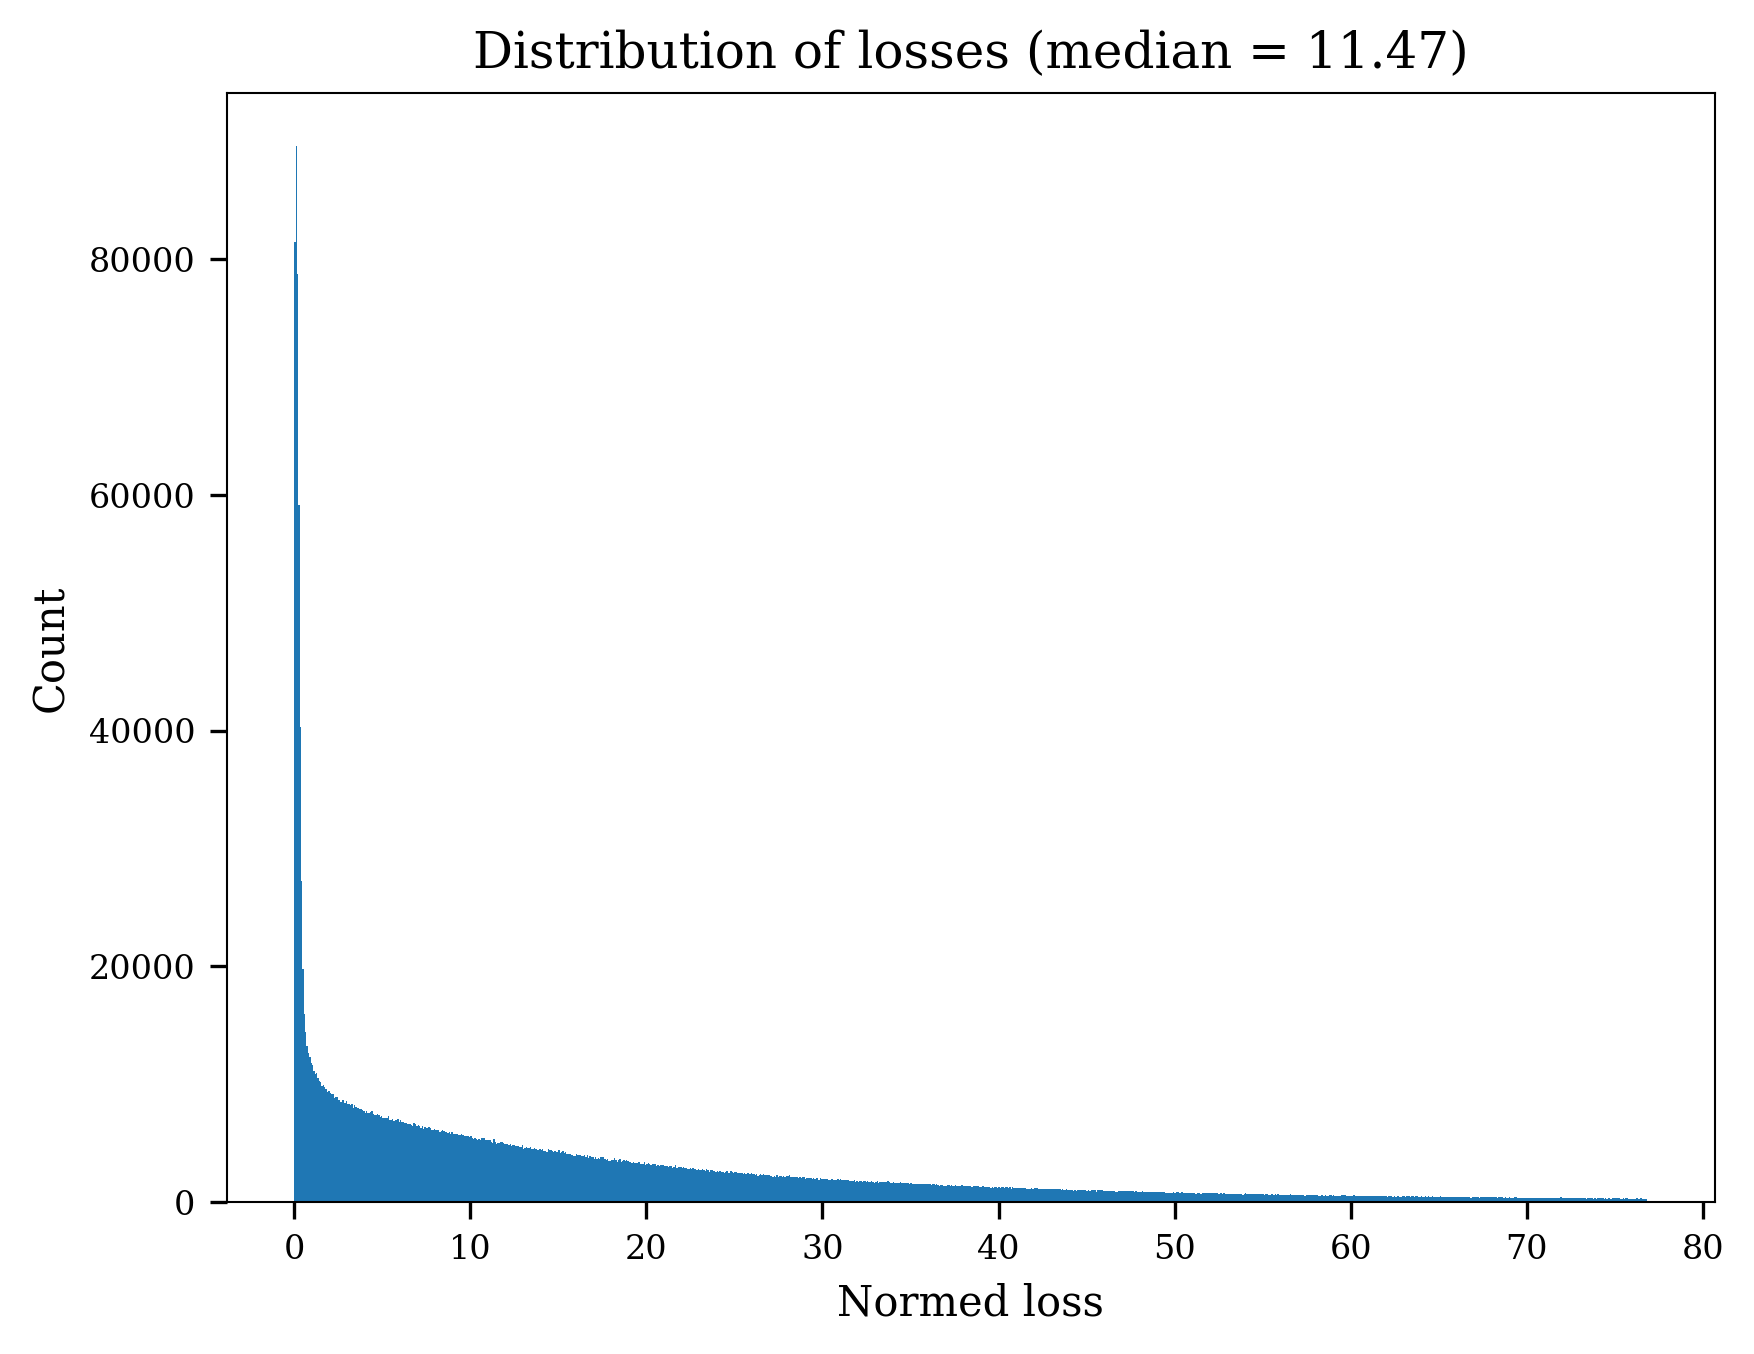

In [32]:
from maspim import Spectra, hdf5Handler
import user_params
import os

# define the path to the .d folder
path_d_folder = os.path.join(user_params.path_folder_test_data, user_params.d_folder_test_data)

spec = Spectra(path_d_folder=path_d_folder, initiate=False)
spec.load()  # pick up after add_calibrated_spectra

# initiate the reader
reader = hdf5Handler(path_d_folder)

spec.set_peaks()
spec.set_kernels(suppress_warnings=True)
spec.bin_spectra(reader)
spec.set_reconstruction_losses(reader)
spec.plot_losses()